# Segmentez des clients d'un site e-commerce

# Sommaire

1. Préambule<br />
 1.1 Problématique<br />
 1.2 Objectifs dans ce projet
2. Import des librairies
3. Définition des fonctions
4. Import et analyse des fichiers à étudier
5. Merge des DataFrames
6. Traitement des catégories manquantes
7. Traitement des variables contenant des Dates
8. Exploration des données<br />
 8.1 Analyse générale des DataFrame<br />
 8.2 Analyse des commandes<br />
 8.3 Analyse des produits<br />
 8.4 Analyse des ventes<br />
 8.5 Analyse des clients<br />
 8.6 Analyse des Reviews
9. Conservation des commandes 'delivered' uniquement
10. Features Engineering<br />
 10.1 Retard de livraison<br />
 10.2 Paiement par carte<br />
 10.3 Score en fonction du type de paiement utilisé<br />
 10.4 Nombre de commande par client<br />
 10.5 Montant total commandé / client<br />
 10.6 Montant total payé / client<br />
 10.7 Panier Moyen / Client<br />
 10.8 Jour de la semaine / commande<br />
 10.9 Mois del'année / commande<br />
 10.10 Délai depuis la dernière commande<br />
 10.11 Satisfaction Client
11. Suppression des colonnes inutiles
12. Filtrage des customer_unique_id
13. Analyse de corrélation
14. Standardisation des données<br />
 14.1 Analyse des données avant Standardisation<br />
 14.2 Analyse des données après Standardisation
15. Standardisation des données
16. Traitement des outliers
17. Sauvegarde et Restauration des DataFrame
 17.1 Sauvegarde des DataFrame<br />
 17.2 Restauration des DataFrame
18. Segmentation des clients<br />
19. Test avec 3 features<br />
 19.1 Coefficient de silhouette<br />
 19.2 K-Means<br />
 19.3 PCA<br />
 19.4 Graphique BoxPlot<br />
 19.5 Diagramme de Kiviat<br />
 19.6 DBSCAN<br />
 19.7 Agglomerative Clustering - Dendrogram<br />
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;19.7.1 Test avec 10 000 données<br />
20. Test avec 4 features<br />
 20.1 Coefficient de silhouette<br />
 20.2 K-Means<br />
 20.3 PCA<br />
 20.4 Graphique BoxPlot<br />
 20.5 Diagramme de Kiviat<br />
 20.6 DBSCAN<br />
 20.7 Agglomerative Clustering - Dendrogram<br />
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;20.7.1 Test avec 10 000 données
21. Test avec 5 features<br />
 21.1 Coefficient de silhouette<br />
 21.2 K-Means<br />
 21.3 PCA<br />
 21.4 Graphique BoxPlot<br />
 21.5 Diagramme de Kiviat<br />
 21.6 DBSCAN<br />
 21.7 Agglomerative Clustering - Dendrogram<br />
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;21.7.1 Test avec 10 000 données
22. Contrat de Maintenance<br />
 22.1 Modèle et nombre de features retenus<br />
 22.2 Description des différentes étapes<br />
 22.3 Création du DataFrame data<br />
 22.4 Création des fonctions necessaires au calcul de l'Ajusted_Rand_Score<br />
 22.5 Affichage de la stabilité des clusters au cours du temps<br />
 22.6 Conclusion & Proposition de contrat de maintenance

# 1. Préambule

## 1.1 Problématique

L'entreprise **Olist** souhaite que nous fournissions à ses équipes <br />
d'e-commerce une segmentation des clients qu’elles pourront utiliser <br />
au quotidien pour leurs campagnes de communication.

## 1.2 Objectifs dans ce projet

<u>Il y en a 3</u> :
 1. Comprendre les différents types d’utilisateurs <br />
    grâce à leur comportement et à leurs données personnelles
 2. Fournir à l’équipe marketing une description actionnable <br />
    de notre segmentation et de sa logique sous-jacente <br />
    pour une utilisation optimale
 3. Réaliser une proposition de contrat de maintenance <br />
    basée sur une analyse de la stabilité des segments au cours du temps

# 2. Import des librairies & réglable Google Colab

In [1]:
# pip install flake8 pycodestyle_magic 
# %load_ext pycodestyle_magic # Verifies that PEP8 is respected
# %pycodestyle_on

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import pickle
import re

from sklearn.preprocessing import PowerTransformer, MinMaxScaler,\
                                  StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [3]:
!pip install --upgrade category_encoders
import category_encoders as ce

Requirement already up-to-date: category_encoders in c:\users\waldu\anaconda3\lib\site-packages (2.2.2)


In [4]:
# Changing Pandas settings for
# be able to display more rows and more columns.
pd.set_option("max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# Deactivating Warnings
pd.options.mode.chained_assignment = None  # default='warn'

# 3. Définition des fonctions

In [5]:
def plot_dendrogram(model, **kwargs):
    '''Create linkage matrix and then plot the dendrogram'''

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [6]:
def exploreFrequencies(myDF):
    '''
    Takes as input the DataFrame myDF
    Displays the output for each column of myDF:
     - The number of unique values
     - The number of missing values
    This function requires that the DataFrame
    has its characteristic 'name' entered beforehand.'''

    print("{0:30} {1:25} {2:25}".format(myDF.name,
                                        "unique values",
                                        "missing values"))
    for i in myDF:
        print("{0:30} {1:20} {2:20}".format(i,
                                            myDF[i].nunique(),
                                            myDF[i].isna().sum()))
    print("------------------------------------")

In [7]:
def calcAverageBasket(data):
    '''
    Calculate and return the average basket value per customer
    The average basket corresponds to the total amount ordered by
    the customer divided by the total number of orders.

    Formula: BasketAverage = TotalOrder / NbOrder

    The total amount ordered by the customer is present
    in the variable <totalOrd>.
    If the information is not present (is 0) then
    I use the data present in <totalPaid>.
    which includes shipping costs.

    The total number of orders (including the value of the product
    is filled in) is present in the variable <nbPrices>.
    If no product value is entered then
    I use the variable <nbOrders>.

    First define the numerator and then
    the denominator of the formula before calculating
    and return the value of the average basket.
    '''

    totalOrd = data['total_amout_ordered']
    totalPaid = data['total_amout_paid']
    nbPrices = data['number_of_prices_filled_in']
    nbOrders = data['total_of_orders']

    if totalOrd > 0:
        numerator = totalOrd
    else:
        numerator = totalPaid

    if nbPrices > 0:
        denominator = nbPrices
    else:
        denominator = nbOrders

    return numerator/denominator

# 4. Import et analyse des fichiers à étudier

**Olist** nous fournit une base de données anonymisée <br />
comportant des informations sur l’historique de commandes,<br />
les produits achetés, les commentaires de satisfaction,<br />
et la localisation des clients depuis janvier 2017.

<u>Voici le schéma de la base de données d'Olist</u> :

<img src="Shema_BDD.png">

<u>J'importe chaque base de donnée dans un DataFrame distinct</u> :

In [8]:
df_customer = pd.read_csv('data/olist_customers_dataset.csv',
                          sep=',')
df_orders = pd.read_csv('data/olist_orders_dataset.csv',
                        sep=',')
df_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv',
                         sep=',')
df_payments = pd.read_csv('data/olist_order_payments_dataset.csv',
                          sep=',')
df_items = pd.read_csv('data/olist_order_items_dataset.csv',
                       sep=',')
df_products = pd.read_csv('data/olist_products_dataset.csv',
                          sep=',')
df_translation = pd.read_csv('data/product_category_name_translation.csv',
                             sep=',')
df_sellers = pd.read_csv('data/olist_sellers_dataset.csv',
                         sep=',')

# 5. Merge des DataFrames

<u>Je merge l'ensemble des DataFrame, <br />
en réalisant systématiquement une **jointure à gauche**,<br />
en partant du DataFrame df_customer</u> :

In [9]:
df = pd.merge(df_customer, df_orders,
              how='left',
              on='customer_id')\
              .merge(df_payments,
                     how='left',
                     on='order_id')\
              .merge(df_items,
                     how='left',
                     on='order_id')\
              .merge(df_products,
                     how='left',
                     on='product_id')\
              .merge(df_translation,
                     how='left',
                     on='product_category_name')\
              .merge(df_sellers,
                     how='left',
                     on='seller_id')
df.head(4).T

,0,1,2,3
customer_id,06b8999e2fba1a1fbc88172c00ba8bc7,18955e83d337fd6b2def6b18a428ac77,4e7b3e00288586ebd08712fdd0374a03,b2b6027bc5c5109e529d4dc6358b12c3
customer_unique_id,861eff4711a542e4b93843c6dd7febb0,290c77bc529b7ac935b93aa66c333dc3,060e732b5b29e8181a18229c7b0b2b5e,259dac757896d24d7702b9acbbff3f3c
customer_zip_code_prefix,14409,9790,1151,8775
customer_city,franca,sao bernardo do campo,sao paulo,mogi das cruzes
customer_state,SP,SP,SP,SP
order_id,00e7ee1b050b8499577073aeb2a297a1,29150127e6685892b6eab3eec79f59c7,b2059ed67ce144a36e2aa97d2c9e9ad2,951670f92359f4fe4a63112aa7306eba
order_status,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-05-16 15:05:35,2018-01-12 20:48:24,2018-05-19 16:07:45,2018-03-13 16:06:38
order_approved_at,2017-05-16 15:22:12,2018-01-12 20:58:32,2018-05-20 16:19:10,2018-03-13 17:29:19
order_delivered_carrier_date,2017-05-23 10:47:57,2018-01-15 17:14:59,2018-06-11 14:31:00,2018-03-27 23:22:42


# 6. Traitement des catégories manquantes

Certaines traductions en anglais de catégories sont manquantes.<br />
<u>Je les ajoutes</u> :

In [10]:
df[['product_category_name',
    'product_category_name_english']] = \
  df[['product_category_name',
      'product_category_name_english']]\
  .append(pd.DataFrame([['pc_gamer', 'pc_gamer'],
                        ['portateis_cozinha_e_preparadores_de_alimentos',
                         'food_preparers_and_kitchen_portals']],
                       columns=['product_category_name',
                                'product_category_name_english']),
          ignore_index=True)

# 7. Traitement des variables contenant des Dates

<u>Je convertis au bon format les colonnes contenant des dates</u> :

In [11]:
df[['order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date']] =\
  df[['order_purchase_timestamp',
      'order_approved_at',
      'order_delivered_carrier_date',
      'order_delivered_customer_date',
      'order_estimated_delivery_date']].apply(pd.to_datetime)

# 8. Exploration des données

## 8.1 Analyse générale des DataFrame

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_zip_code_prefix,118434.00000,35034.26439,29819.29022,1003.00000,11310.00000,24240.00000,58464.50000,99990.00000
payment_sequential,118431.00000,1.09421,0.72829,1.00000,1.00000,1.00000,1.00000,29.00000
payment_installments,118431.00000,2.93740,2.77416,0.00000,1.00000,2.00000,4.00000,24.00000
payment_value,118431.00000,172.84939,268.25983,0.00000,60.86000,108.20000,189.24500,13664.08000
order_item_id,117604.00000,1.19592,0.69772,1.00000,1.00000,1.00000,1.00000,21.00000
price,117604.00000,120.82285,184.47737,0.85000,39.90000,74.90000,134.90000,6735.00000
freight_value,117604.00000,20.04555,15.86135,0.00000,13.08000,16.29000,21.19000,409.68000
product_name_lenght,115906.00000,48.76721,10.03516,5.00000,42.00000,52.00000,57.00000,76.00000
product_description_lenght,115906.00000,786.95730,653.02901,4.00000,347.00000,601.00000,985.00000,3992.00000
product_photos_qty,115906.00000,2.20785,1.71952,1.00000,1.00000,1.00000,3.00000,20.00000


<u>J'attribue un nom à chaque DataFrame <br />
avant d'afficher leurs caractéristiques</u> :
 - Nombre de valeurs unique pour chaque colonne
 - Nombre de valeurs manquantes pour chaque colonne

In [13]:
df_customer.name = 'df_customer'
df_orders.name = 'df_orders'
df_payments.name = 'df_payments'
df_items.name = 'df_items'
df_products.name = 'df_products'
df_translation.name = 'df_translation'
df_sellers.name = 'df_sellers'

In [14]:
exploreFrequencies(df_customer)
exploreFrequencies(df_orders)
exploreFrequencies(df_payments)
exploreFrequencies(df_items)
exploreFrequencies(df_products)
exploreFrequencies(df_translation)
exploreFrequencies(df_sellers)

df_customer                    unique values             missing values           
customer_id                                   99441                    0
customer_unique_id                            96096                    0
customer_zip_code_prefix                      14994                    0
customer_city                                  4119                    0
customer_state                                   27                    0
------------------------------------
df_orders                      unique values             missing values           
order_id                                      99441                    0
customer_id                                   99441                    0
order_status                                      8                    0
order_purchase_timestamp                      98875                    0
order_approved_at                             90733                  160
order_delivered_carrier_date                  81018                

## 8.2 Analyse des commandes

<u>Listing des différents statuts <br />
possibles pour une commande</u> :

In [15]:
df_orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

<u>Focus sur les statuts contenant <br />
des valeurs manquantes</u> :

In [16]:
orders_missing_values = (df_orders.isnull().sum())
print(orders_missing_values[orders_missing_values > 0])

order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64


## 8.3 Analyse des produits

### <u>Nombre de produit référencés par catégorie</u> :

In [17]:
df_products.product_category_name.value_counts()

cama_mesa_banho                                   3029
esporte_lazer                                     2867
moveis_decoracao                                  2657
beleza_saude                                      2444
utilidades_domesticas                             2335
automotivo                                        1900
informatica_acessorios                            1639
brinquedos                                        1411
relogios_presentes                                1329
telefonia                                         1134
bebes                                              919
perfumaria                                         868
fashion_bolsas_e_acessorios                        849
papelaria                                          849
cool_stuff                                         789
ferramentas_jardim                                 753
pet_shop                                           719
eletronicos                                        517
construcao

### <u>Nombre de valeurs manquantes par produit (description)</u> :

In [18]:
products_missing_values = (df_products.isnull().sum())
print(products_missing_values[products_missing_values > 0])

product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


### <u>Catégories qui recensent le plus de produits</u> :

In [19]:
df_products.product_category_name.value_counts()

cama_mesa_banho                                   3029
esporte_lazer                                     2867
moveis_decoracao                                  2657
beleza_saude                                      2444
utilidades_domesticas                             2335
automotivo                                        1900
informatica_acessorios                            1639
brinquedos                                        1411
relogios_presentes                                1329
telefonia                                         1134
bebes                                              919
perfumaria                                         868
fashion_bolsas_e_acessorios                        849
papelaria                                          849
cool_stuff                                         789
ferramentas_jardim                                 753
pet_shop                                           719
eletronicos                                        517
construcao

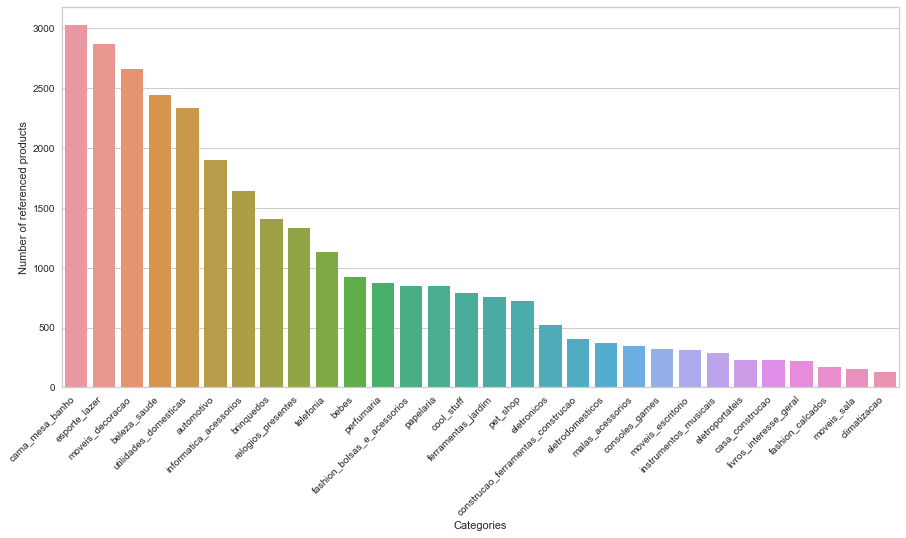

In [20]:
productsByCategory = \
  df_products.product_category_name.value_counts()

plt.figure(figsize=(15, 7))
sns.barplot(x=productsByCategory.index[:30],
            y=productsByCategory.values[:30])
plt.xlabel('Categories')
plt.ylabel('Number of referenced products')
# plt.xticks(rotation=-90)
plt.xticks(rotation=45, ha='right')
plt.show()

### <u>Prix des produits</u> :

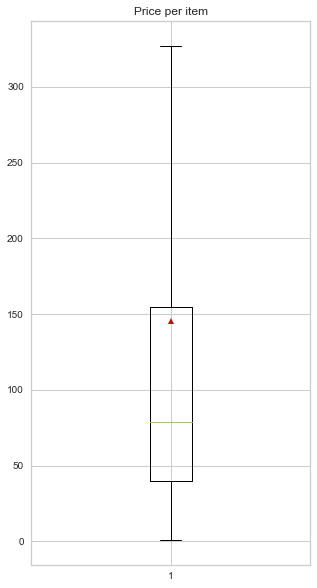

In [21]:
plt.figure(figsize=(5, 10))
plt.boxplot(df_items.groupby('product_id').mean()['price'],
            showfliers=False,
            showmeans=True)
plt.title('Price per item')
plt.show()

## 8.4 Analyse des ventes

### Nombre de vente / Catégorie

In [22]:
df_orders_items_product = pd.merge(df_orders, df_items, on='order_id', how='left')\
                            .merge(df_products, on='product_id', how='left')

In [23]:
df_orders_items_product.product_category_name.value_counts()[:30]

cama_mesa_banho                      11115
beleza_saude                          9670
esporte_lazer                         8641
moveis_decoracao                      8334
informatica_acessorios                7827
utilidades_domesticas                 6964
relogios_presentes                    5991
telefonia                             4545
ferramentas_jardim                    4347
automotivo                            4235
brinquedos                            4117
cool_stuff                            3796
perfumaria                            3419
bebes                                 3065
eletronicos                           2767
papelaria                             2517
fashion_bolsas_e_acessorios           2031
pet_shop                              1947
moveis_escritorio                     1691
consoles_games                        1137
malas_acessorios                      1092
construcao_ferramentas_construcao      929
eletrodomesticos                       771
instrumento

### <u>Volume des 30 produits les plus vendus</u> :

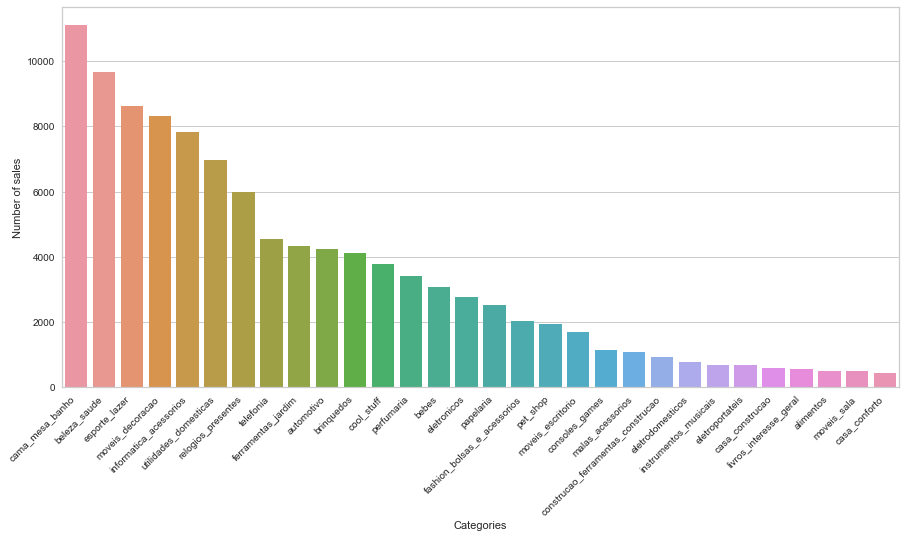

In [24]:
plt.figure(figsize=(15, 7))
sns.barplot(x=df_orders_items_product.product_category_name
            .value_counts()[:30].index,
            y=df_orders_items_product.product_category_name
            .value_counts()[:30].values)
plt.xlabel('Categories')
plt.ylabel('Number of sales')
plt.xticks(rotation=45, ha='right')
plt.show()

### <u>Volume monétaire des ventes des 30 premières catégories (en euros)</u> :

In [25]:
df_orders_items_product.groupby('product_category_name')\
  .sum()['price'].sort_values(ascending=False)[:30]

product_category_name
beleza_saude                        1258681.34000
relogios_presentes                  1205005.68000
cama_mesa_banho                     1036988.68000
esporte_lazer                        988048.97000
informatica_acessorios               911954.32000
moveis_decoracao                     729762.49000
cool_stuff                           635290.85000
utilidades_domesticas                632248.66000
automotivo                           592720.11000
ferramentas_jardim                   485256.46000
brinquedos                           483946.60000
bebes                                411764.89000
perfumaria                           399124.87000
telefonia                            323667.53000
moveis_escritorio                    273960.70000
papelaria                            230943.23000
pcs                                  222963.13000
pet_shop                             214315.41000
instrumentos_musicais                191498.88000
eletroportateis             

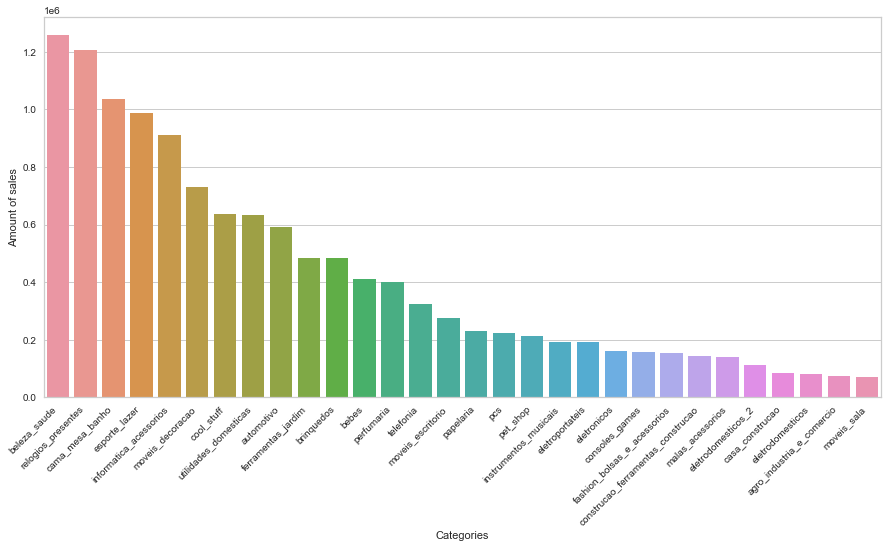

In [26]:
amoutOfSalesByCategory = df_orders_items_product\
                         .groupby('product_category_name')\
                         .sum()['price']\
                         .sort_values(ascending=False)[:30]
plt.figure(figsize=(15, 7))
sns.barplot(x=amoutOfSalesByCategory.index,
            y=amoutOfSalesByCategory.values)
plt.xlabel('Categories')
plt.ylabel('Amount of sales')
plt.xticks(rotation=45, ha='right')
plt.show()

### <u>Montant moyen par commande (sans Outliers)</u> :

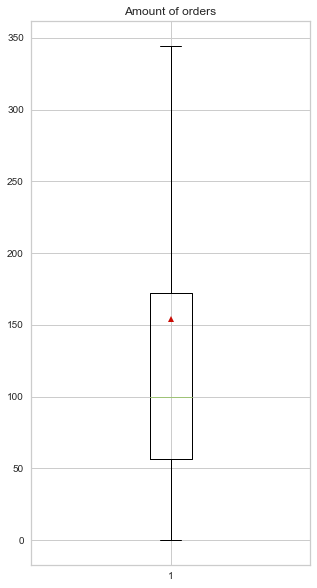

In [27]:
plt.figure(figsize=(5, 10))
plt.boxplot(df_payments.payment_value,
            showfliers=False,
            showmeans=True)
plt.title('Amount of orders')
plt.show()

## 8.5 Analyse des clients

### Nombre et pourcentage de clients par pays

In [28]:
df_customer.customer_state.value_counts()

SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_state, dtype: int64

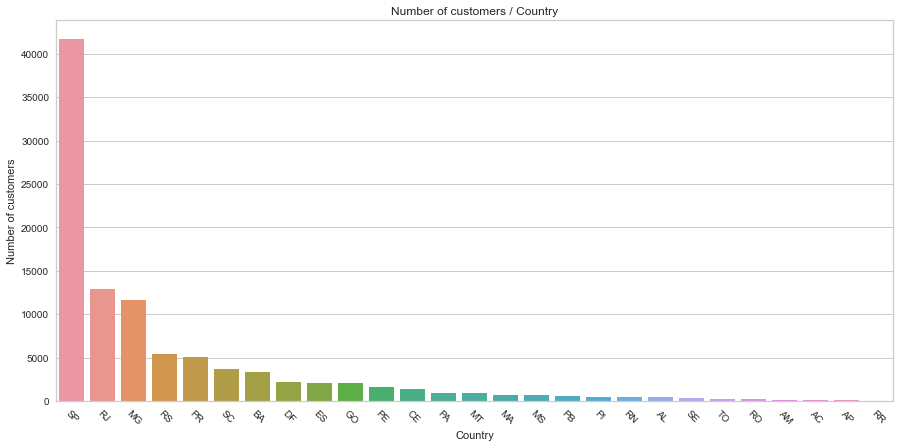

In [29]:
plt.figure(figsize=(15, 7))
sns.barplot(x=df_customer.customer_state.value_counts().index,
            y=df_customer.customer_state.value_counts().values)
plt.title('Number of customers / Country')
plt.xlabel('Country')
plt.ylabel('Number of customers')
plt.xticks(rotation=-45)
plt.show()

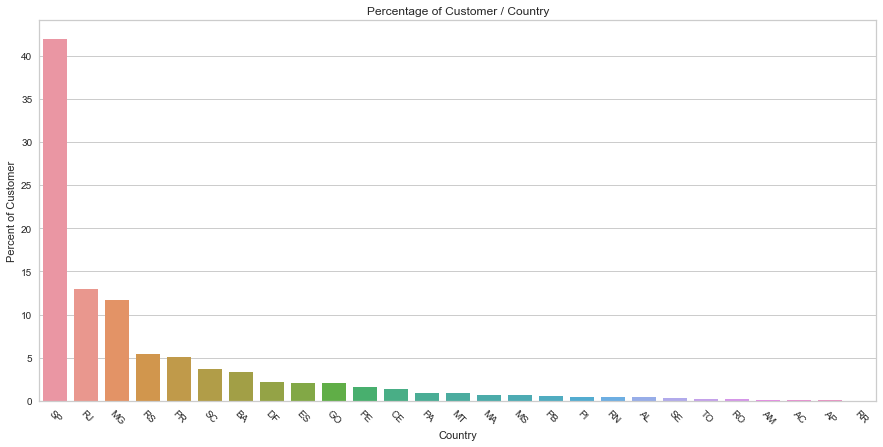

In [30]:
plt.figure(figsize=(15, 7))
sns.barplot(x=df_customer.customer_state
            .value_counts(normalize=True).index,
            y=df_customer.customer_state
            .value_counts(normalize=True).values*100)
plt.title('Percentage of Customer / Country')
plt.xlabel('Country')
plt.ylabel('Percent of Customer')
plt.xticks(rotation=-45)
plt.show()

## 8.6 Analyse des Reviews

### <u>Pourcentage de reviews renseignées par les clients</u> :

In [31]:
(df_reviews[['review_comment_title',
             'review_comment_message']].notnull().sum()
 / len(df_reviews)) * 100

review_comment_title     11.71500
review_comment_message   41.75300
dtype: float64

### <u>Moyenne des reviews</u> :

In [32]:
df_reviews.review_score.value_counts(normalize=True)*100

5   57.42000
4   19.20000
1   11.85800
3    8.28700
2    3.23500
Name: review_score, dtype: float64

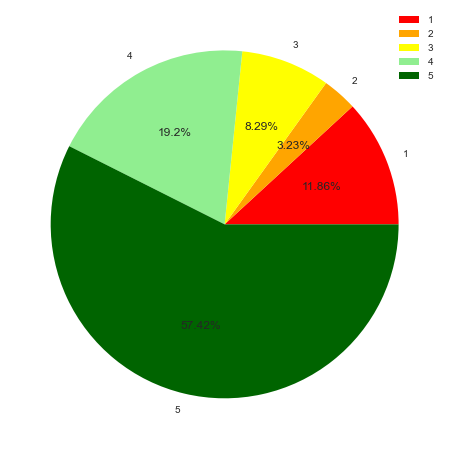

In [33]:
plt.figure(figsize=(8, 8))
plt.pie((df_reviews.review_score.value_counts(normalize=True)*100)
        .sort_index().values,
        labels=['1', '2', '3', '4', '5'],
        autopct=lambda x: str(round(x, 2)) + '%',
        colors=['red', 'orange', 'yellow', 'lightgreen', 'darkgreen'],
        normalize=True)
plt.legend()

# 9. Conservation des commandes 'delivered' uniquement

Pour la suite du projet, nous nous intéressons <br />
qu'aux commandes qui ont été **livrées**.<br />
Je filtre les autres commandes (envoyées, annulées, ...)

In [34]:
df.order_status.value_counts()

delivered      115038
shipped          1245
canceled          745
unavailable       650
processing        375
invoiced          373
created             5
approved            3
Name: order_status, dtype: int64

In [35]:
df = df[df.order_status == 'delivered']

# 10. Features Engineering

<u>Nous allons maintenant créer/calculer de nouvelles variables <br />
à partir des informations que nous avons à notre disposition</u> :

L'objectif est de comprendre nos clients et d'obtenir <br />
des informations précises, qui décrieront au mieux leurs <br />
comportements d'achat et l'expérience qu'ils ont eu <br />
lors de leur(s) commande(s) sur Olist.

<u>Ainsi, pour un client donné nous allons chercher à savoir</u>:
 - Combien d'achat à t'il effectué?
 - A t'il en moyenne été livré dans les temps ?<br />
   de combien de jours en avances ou en retards <br />
   sur la date prévisionnelle de livraison?
 - Quelle est son panier moyen ?
 - Quelle est le montant total qu'il a dépensé ?
 - Quel est son type de moyen de paiement préféré ?
 - A t'il été satisfait du service ?

## 10.1 Retard de livraison

<u>Indique, en jours, la différence entre la date <br />
de livraison réelle, et la date de livraison prévisionnelle</u> :
 - Une valeur <u>positive</u> indique une livraison effectuée en **avance**.<br />
 - Une valeur <u>négative</u> indique un **retard** de livraison

In [36]:
df['late_delivery'] = (df.order_delivered_customer_date -
                       df.order_estimated_delivery_date)\
                       .astype('timedelta64[D]')
df['late_delivery'] = df['late_delivery']*-1

<u>Suppression des 8 commandes n'ayant pas de 'late_delivery'</u> :

In [37]:
df = df[~df.late_delivery.isnull()]

<u>On ne conserve que les moyennes des valeurs / client</u> :

In [38]:
df = df.drop('late_delivery',
             axis=1)\
       .merge(df.groupby('customer_unique_id')
              .mean()[['late_delivery']],
              on='customer_unique_id',
              how='left')

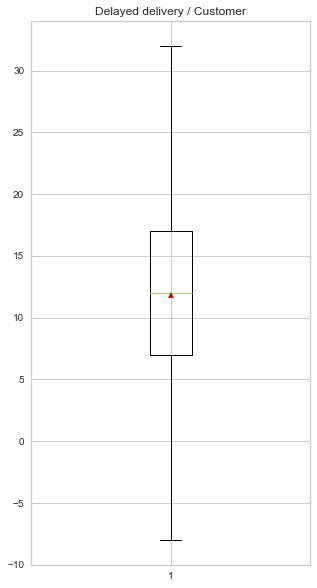

In [39]:
plt.figure(figsize=(5, 10))
plt.boxplot(df.groupby('customer_unique_id').mean()['late_delivery'],
            showfliers=False,
            showmeans=True)
plt.title('Delayed delivery / Customer')
plt.show()

## 10.2 Paiements par carte

In [40]:
df.payment_type.value_counts()

credit_card    84889
boleto         22362
voucher         6123
debit_card      1653
Name: payment_type, dtype: int64

<u>Je renseigne les valeurs manquantes par l'indication '**not_defined**'</u> :

In [41]:
df['payment_type'] = df['payment_type'].fillna('not_defined')

Je décide de ne conserver que l'information de paiement '**par carte**'<br />
en mutualisant les paiements par carte de *crédit* et carte de *débit*.

In [42]:
df.loc[df['payment_type'].str.contains('card'), 'payment_type'] = 'card'

In [43]:
df.payment_type.value_counts()

card           86542
boleto         22362
voucher         6123
not_defined        3
Name: payment_type, dtype: int64

## 10.3 Score en fonction du type de paiement utilisé

<u>Pour identifier les clients selon leur moyen de paiement préféré, je leur attribue un score</u> :

<AxesSubplot:title={'center':'methods of payment'}>

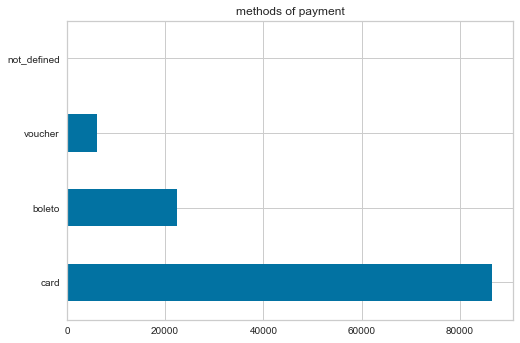

In [44]:
p_type = df.payment_type.value_counts()
p_type.plot(kind='barh', title="methods of payment")

In [45]:
df = df.merge(df[['customer_unique_id', 'payment_type']]
              .replace(p_type.index, p_type.values)
              .rename(columns={'payment_type': 'payment_type_score'}),
              on='customer_unique_id',
              how='left')

## 10.4 Nombre de commandes par client

In [46]:
df_sumOrd = df[['customer_unique_id', 'customer_id']]\
            .groupby('customer_unique_id').nunique()
df_sumOrd.rename(columns={'customer_id': 'total_of_orders'}, inplace=True)
df_sumOrd.sort_values(by='total_of_orders', ascending=False)

,total_of_orders
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,15
3e43e6105506432c953e165fb2acf44c,9
6469f99c1f9dfae7733b25662e7f1782,7
ca77025e7201e3b30c44b472ff346268,7
1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...
565af81202a1fb8a9ffe282935381142,1
56583a02df6f603c331a575f4f63ec6b,1
565811ed44e539a14bc391cf57373ed1,1


In [47]:
df = df.merge(df_sumOrd, on='customer_unique_id', how='left')

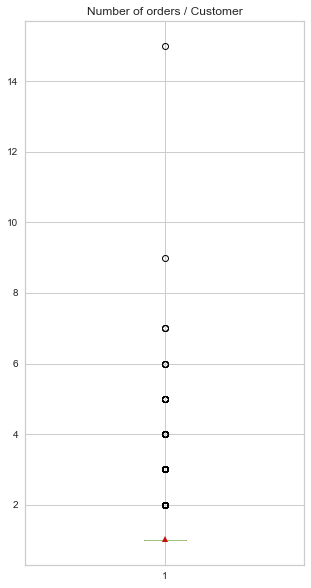

In [48]:
plt.figure(figsize=(5, 10))
plt.boxplot(df.groupby('customer_unique_id').mean()['total_of_orders'],
            showfliers=True,
            showmeans=True)
plt.title('Number of orders / Customer')
plt.show()

In [49]:
df.total_of_orders.value_counts(normalize=False, sort=False)

1     170521
2      27607
3       3597
4       1355
5        295
6        363
7        325
9        196
15       225
Name: total_of_orders, dtype: int64

In [50]:
df.total_of_orders.value_counts(normalize=True, sort=False)

1    0.83391
2    0.13501
3    0.01759
4    0.00663
5    0.00144
6    0.00178
7    0.00159
9    0.00096
15   0.00110
Name: total_of_orders, dtype: float64

Plus de **83%** des clients n'ont réalisés qu'une seule commande sur le site.<br />
**13.5%** ont réalisé 2 commandes.<br />
**3.1%** seulement des clients ont réalisés plus de 2 commandes.

## 10.5 Montant total commandé / client

In [51]:
df_totalAmoutOrdered = df.groupby(['customer_unique_id']).sum()\
                         .rename(columns={'price': 'total_amout_ordered'})
df = df.merge(df_totalAmoutOrdered['total_amout_ordered'],
              on='customer_unique_id',
              how='left')

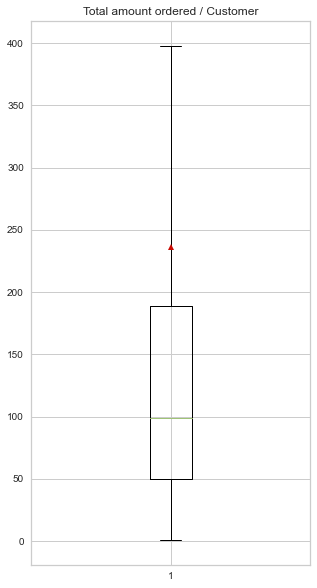

In [52]:
plt.figure(figsize=(5, 10))
plt.boxplot(df.groupby('customer_unique_id').mean()['total_amout_ordered'],
            showfliers=False,
            showmeans=True)
plt.title('Total amount ordered / Customer')
plt.show()

## 10.6 Montant total payé / client

In [53]:
df_totalAmoutPaid = df.groupby(['customer_unique_id']).sum()\
                      .rename(columns={'payment_value': 'total_amout_paid'})
df = df.merge(df_totalAmoutPaid['total_amout_paid'],
              on='customer_unique_id',
              how='left')

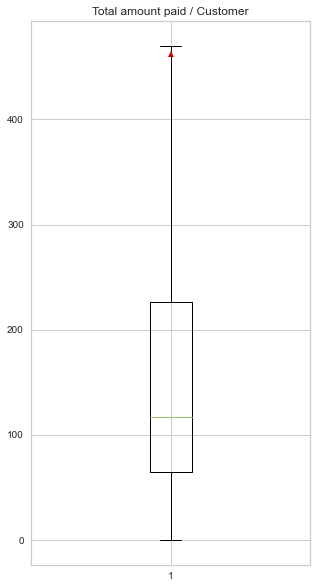

In [54]:
plt.figure(figsize=(5, 10))
plt.boxplot(df.groupby('customer_unique_id').mean()['total_amout_paid'],
            showfliers=False,
            showmeans=True)
plt.title('Total amount paid / Customer')
plt.show()

## 10.7 Panier Moyen / Client

### Calcul du nombre d'articles par commande

In [55]:
df = df.merge(df.groupby(['customer_unique_id', 'customer_id'])
              .nunique().groupby('customer_unique_id').sum()['price']
              .reset_index().rename(columns={'price':'number_of_prices_filled_in'}), 
              on='customer_unique_id', how='left')

### Calcul du panier moyen

In [56]:
df['average_basket'] = df.apply(lambda row: calcAverageBasket(row),
                                axis=1)

### Suppression de la colonne indiquant le nombre d'articles par commande

In [57]:
df.drop('number_of_prices_filled_in',
        axis=1,
        inplace=True)

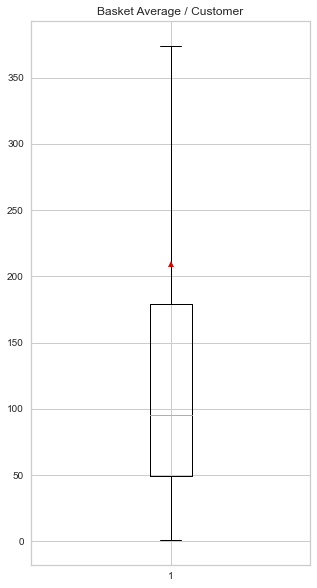

In [58]:
plt.figure(figsize=(5, 10))
plt.boxplot(df.groupby('customer_unique_id').mean()['average_basket'],
            showfliers=False,
            showmeans=True)
plt.title('Basket Average / Customer')
plt.show()

## 10.8 Jour de la semaine / commande

In [59]:
df['day_of_order'] = df.order_approved_at.dt.weekday

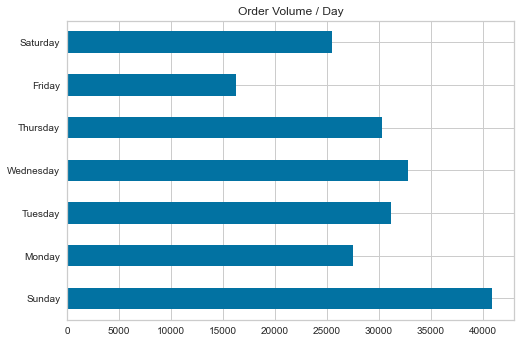

In [60]:
d_order = df.day_of_order.value_counts(sort=False)
d_order.index = ['Sunday',
                 'Monday',
                 'Tuesday',
                 'Wednesday',
                 'Thursday',
                 'Friday',
                 'Saturday']
d_order.plot(kind='barh', title="Order Volume / Day")
plt.show()

## 10.9 Mois de l'année / commande

In [61]:
df['month_of_order'] = df.order_approved_at.dt.month

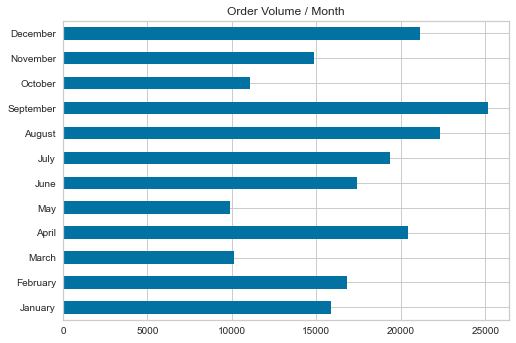

In [62]:
m_order = df.month_of_order.value_counts(sort=False)
m_order.index = ['January',
                 'February',
                 'March',
                 'April',
                 'May',
                 'June',
                 'July',
                 'August',
                 'September',
                 'October',
                 'November',
                 'December']
m_order.plot(kind='barh', title="Order Volume / Month")
plt.show()

## 10.10 Délai depuis la dernière commande

<u>Calcul de la date de la dernière commande existante<br />
comme date de référence pour le calcul de la récence <br />
de chaque commande pour chaque client</u> :

In [63]:
lastOrder = df.order_approved_at.max()
df['days_since_last_order'] = (lastOrder - df.order_purchase_timestamp)\
                              .astype('timedelta64[D]')

<u>On ne conserve que la valeur de la commande la plus récente</u> :

In [64]:
df_recency = df[['customer_unique_id',
                 'days_since_last_order']]\
            .groupby('customer_unique_id').min()

In [65]:
df = df.drop('days_since_last_order',
             axis=1).merge(df_recency,
                           on='customer_unique_id',
                           how='left')

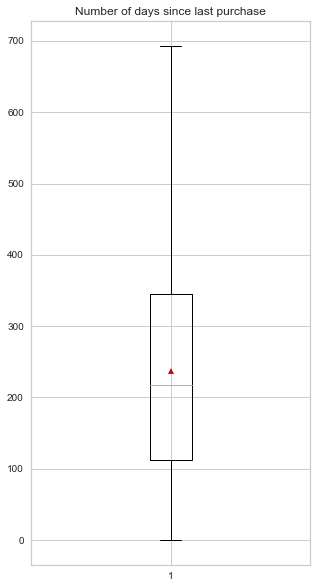

In [66]:
plt.figure(figsize=(5, 10))
plt.boxplot(df.groupby('customer_unique_id').mean()['days_since_last_order'],
            showfliers=False,
            showmeans=True)
plt.title('Number of days since last purchase')
plt.show()

## 10.11 Satisfaction Client

In [67]:
df_customer_orders_reviews = df_customer\
                            .merge(df_orders,
                                   on='customer_id',
                                   how='left')\
                            .merge(df_reviews,
                                   on='order_id',
                                   how='left')\
                            .rename(columns={'review_score':
                                             'customer_satisfaction'})\
                            .groupby('customer_unique_id').mean()

In [68]:
df = df.merge(df_customer_orders_reviews['customer_satisfaction'],
              on='customer_unique_id',
              how='left')

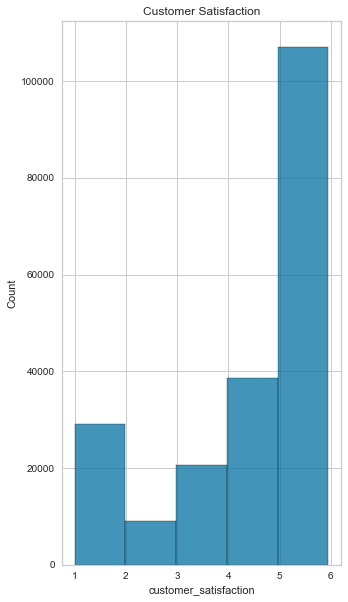

In [69]:
plt.figure(figsize=(5, 10))
sns.histplot(df.customer_satisfaction, binwidth=0.99)
plt.title('Customer Satisfaction')
plt.show()

# 11. Suppression des colonnes inutiles

In [70]:
list(df.columns)

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'order_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'product_category_name_english',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'late_delivery',
 'payment_type_score',
 'total_of_orders',
 'total_amout_ordered',
 'total_amout_paid',
 'average_basket',
 'day_of_order',
 'month_of_order',
 'days_since_last_order',
 'customer_satisfaction']

In [71]:
df.drop(['customer_id',
         'customer_city',
         'customer_state',
         'customer_zip_code_prefix',
         'order_id',
         'order_status',
         'order_purchase_timestamp',
         'order_approved_at',
         'order_delivered_carrier_date',
         'order_delivered_customer_date',
         'order_estimated_delivery_date',
         'payment_sequential',
         'payment_installments',
         'payment_type',
         'payment_value',
         'order_item_id',
         'product_id',
         'seller_id',
         'shipping_limit_date',
         'price',
         'freight_value',
         'product_category_name',
         'product_name_lenght',
         'product_description_lenght',
         'product_photos_qty',
         'product_weight_g',
         'product_length_cm',
         'product_height_cm',
         'product_width_cm',
         'product_category_name_english',
         'seller_zip_code_prefix',
         'seller_city',
         'seller_state'], axis=1, inplace=True)

df.head(4).T

,0,1,2,3
customer_unique_id,861eff4711a542e4b93843c6dd7febb0,290c77bc529b7ac935b93aa66c333dc3,060e732b5b29e8181a18229c7b0b2b5e,259dac757896d24d7702b9acbbff3f3c
late_delivery,11.00000,8.00000,-1.00000,13.00000
payment_type_score,86542,86542,86542,86542
total_of_orders,1,1,1,1
total_amout_ordered,124.99000,289.00000,139.94000,149.94000
total_amout_paid,146.87000,335.48000,157.73000,173.30000
average_basket,124.99000,289.00000,139.94000,149.94000
day_of_order,1.00000,4.00000,6.00000,1.00000
month_of_order,5.00000,1.00000,5.00000,3.00000
days_since_last_order,470.00000,228.00000,101.00000,168.00000


# 12. Filtrage des customer_unique_id

L'objectif ici est de ne conserver qu'une seule entrée / client.<br />
Un client est identifié par son identifiant '*customer_unique_id*'.

<u>Dimension de **df** *avant* filtrage des clients</u> :

In [72]:
df.shape

(204484, 11)

<u>On ne conserve qu'un seul enregistrement de chaque client</u> :<br />

In [73]:
df.drop_duplicates('customer_unique_id', keep='last', inplace=True)

<u>Je supprime également la colonne '**customer_unique_id**',<br />
les clients étant maintenant identifiés par leur **Index**</u> :

In [74]:
df.drop('customer_unique_id', axis=1, inplace=True)

<u>Dimension de **df** *après* filtrage des clients</u> :

In [75]:
df.shape

(93350, 10)

# 13. Analyse de corrélation

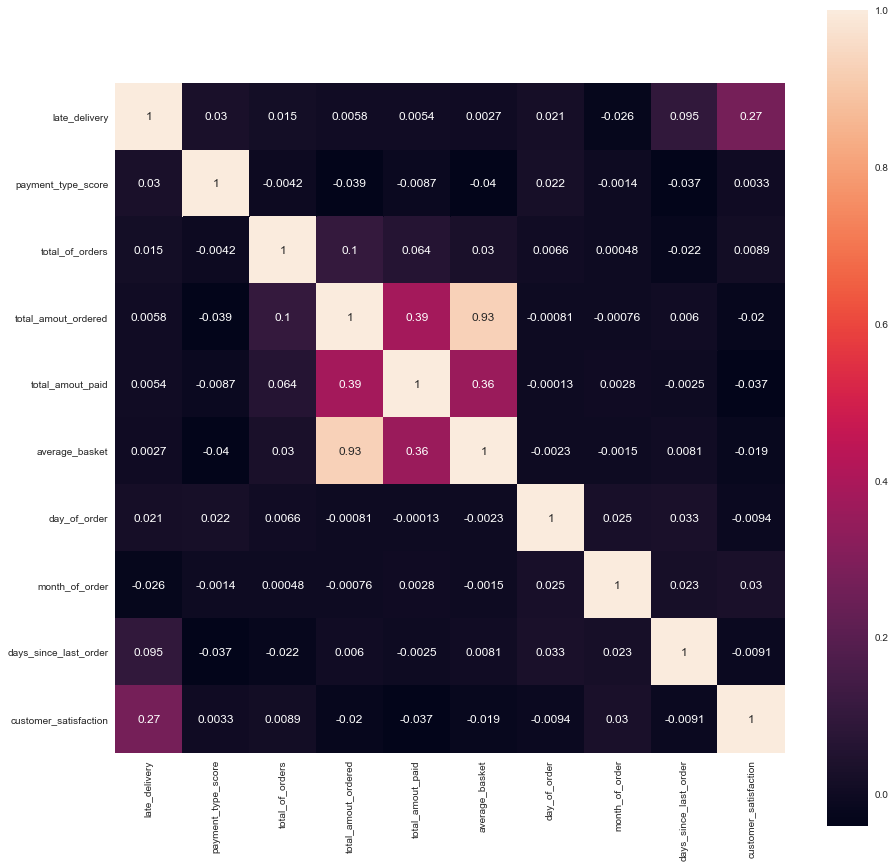

In [76]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

Globalement les features ne sont pas corrélées entre-elles.<br />
Cependant, quelques exceptions :
 - La valeur du panier moyen et du total d'achat sont très corrélés 93% <br />
   compte tenu que la majorité des clients n'ont réalisé qu'une seule commande sur le site.
 - La satisfaction client est également corrélé à 27% avec la rapidité de livraison.
 - Le nombre de versement choisi à l'achat est corrélé à 37% avec le mode de paiement choisi.
 - Tout ce qui fait référence aux montants payés (avec ou sans frais port, etc. ) sont corrélés entre-eux.

# 14. Standardisation des données

L'objectif à cette étape est de ramener les données sur une même échelles.<br />
Nous essayons également d'obtenir une distribution des données qui <br />
se rapproche le plus possible d'une distribution *Normale*.

## 14.1 Analyse des données avant Standardisation

In [77]:
df.head().T

,0,1,2,3,4
late_delivery,11.00000,8.00000,-1.00000,13.00000,6.00000
payment_type_score,86542.00000,86542.00000,86542.00000,86542.00000,86542.00000
total_of_orders,1.00000,1.00000,1.00000,1.00000,1.00000
total_amout_ordered,124.99000,289.00000,139.94000,149.94000,230.00000
total_amout_paid,146.87000,335.48000,157.73000,173.30000,252.25000
average_basket,124.99000,289.00000,139.94000,149.94000,230.00000
day_of_order,1.00000,4.00000,6.00000,1.00000,6.00000
month_of_order,5.00000,1.00000,5.00000,3.00000,7.00000
days_since_last_order,470.00000,228.00000,101.00000,168.00000,31.00000
customer_satisfaction,4.00000,5.00000,5.00000,5.00000,5.00000


C:\Users\waldu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\waldu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\waldu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

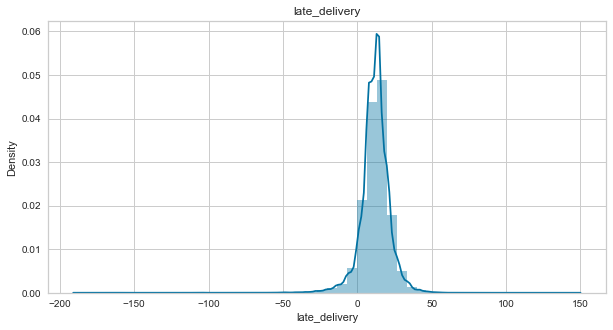

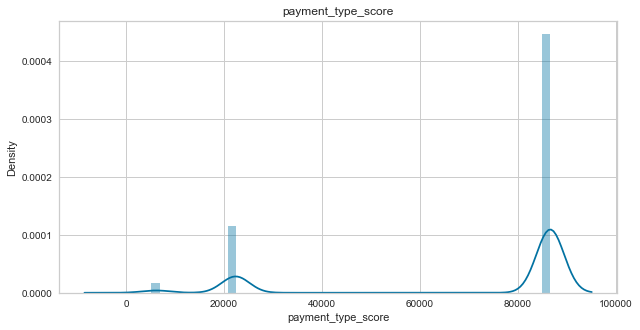

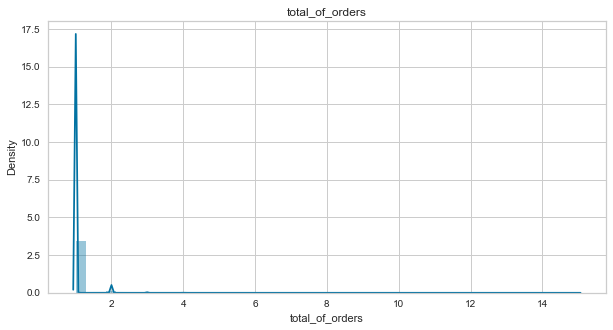

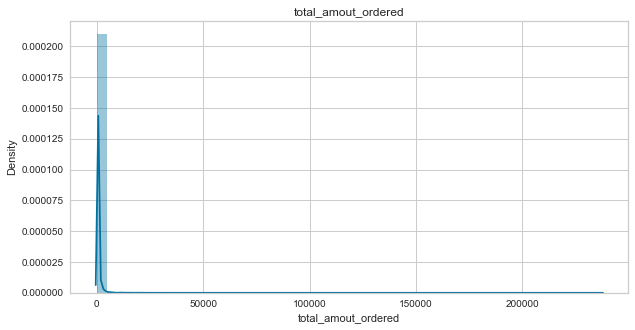

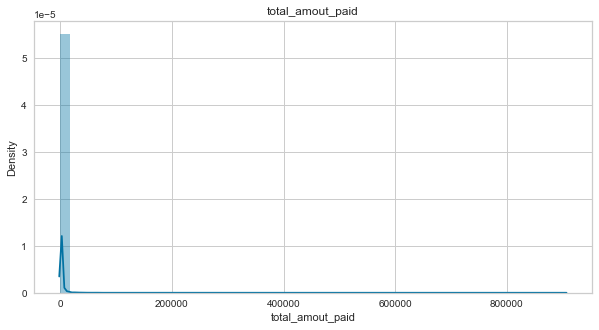

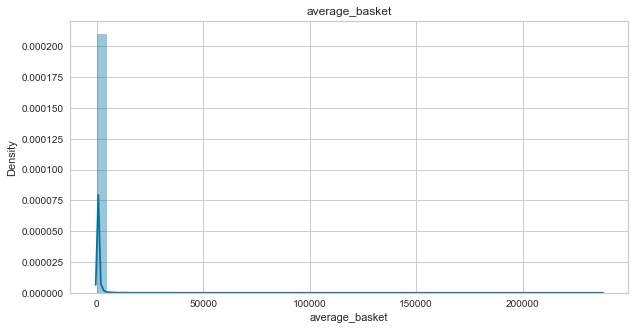

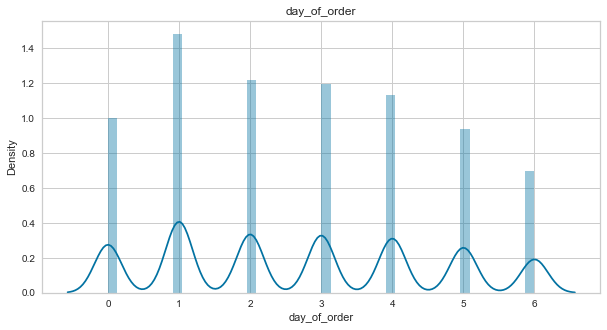

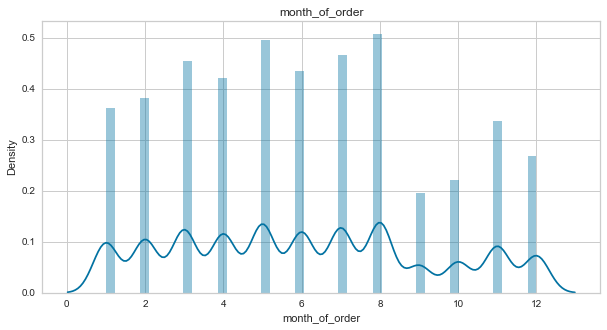

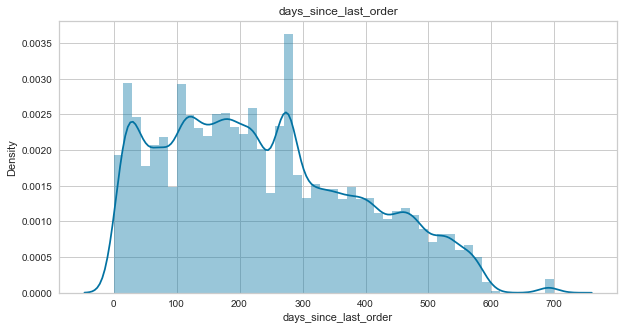

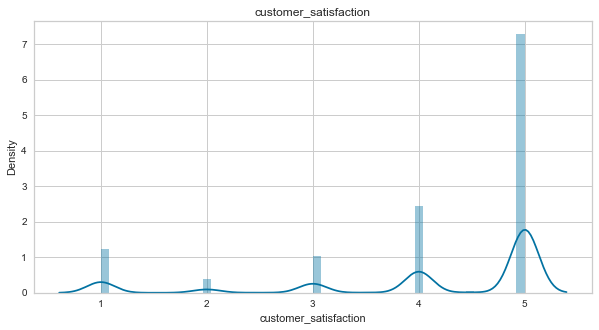

In [78]:
for i in df:
    plt.figure(figsize=(10, 5))
    sns.distplot(df[i])
    plt.title(i)

## 14.2 Analyse des données après Standardisation

J'utilise la fonction **PowerTransform**<br />
et je compare le résultat en utilisant <br />
les méthodes **Yeo-Johnson** et **Box-Cox**.

A noter que la transformation **Box-Cox** <br />
ne peut s'appliquer que sur des <u>valeurs strictement positives</u>.

C:\Users\waldu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\waldu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\waldu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

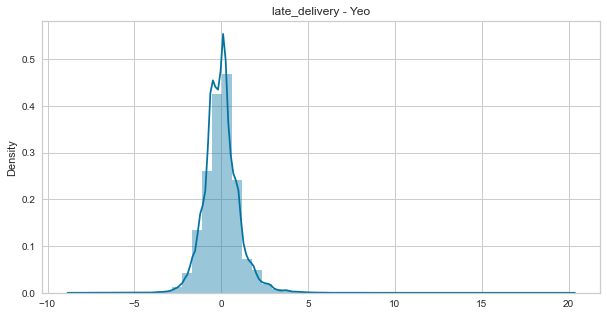

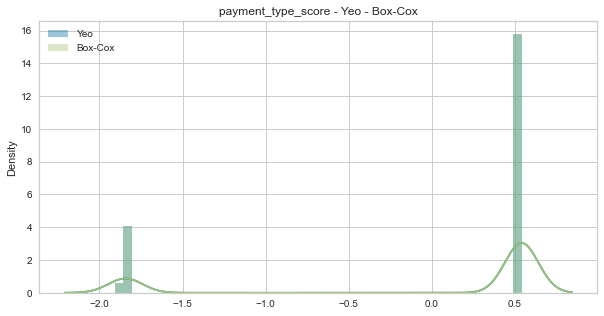

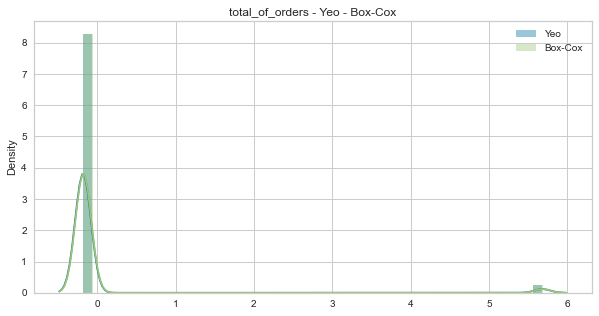

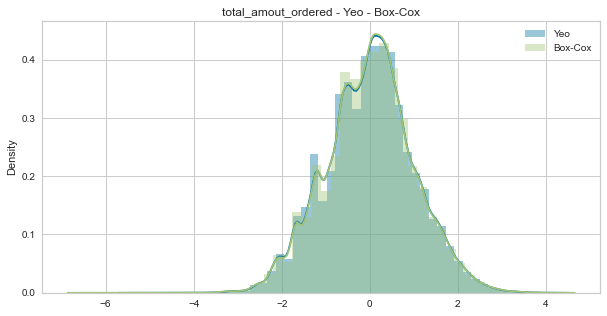

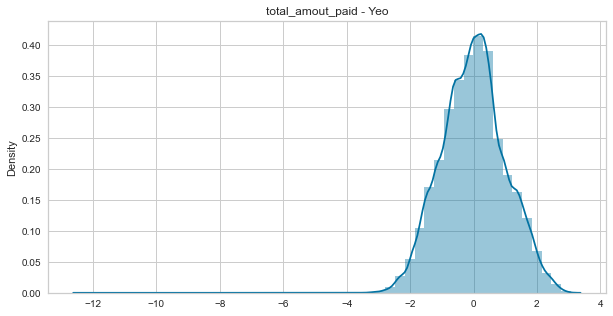

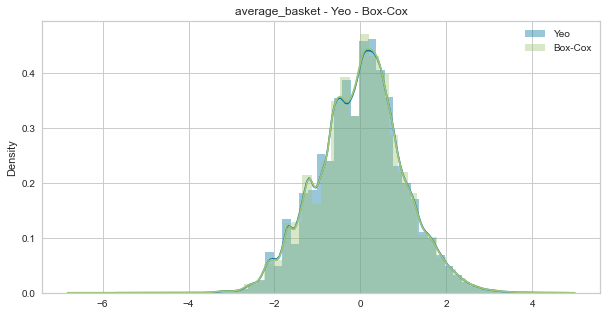

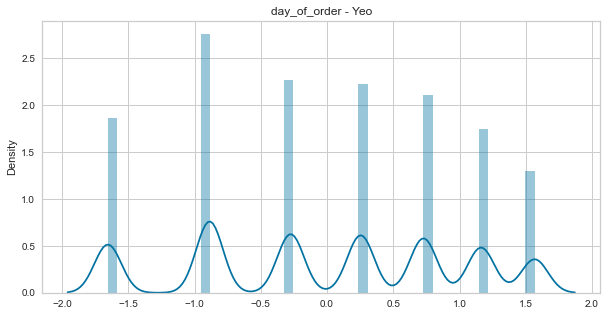

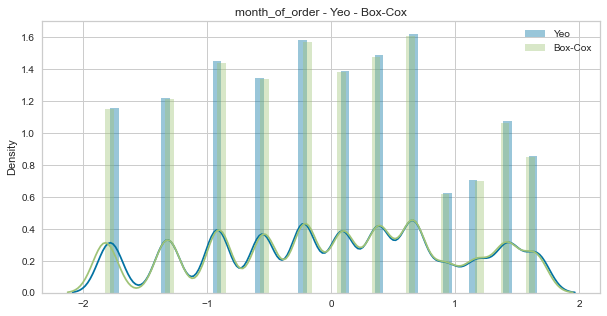

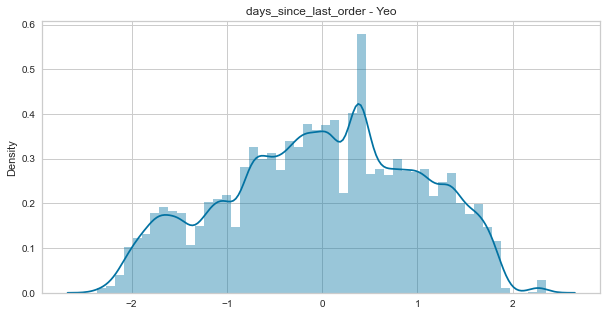

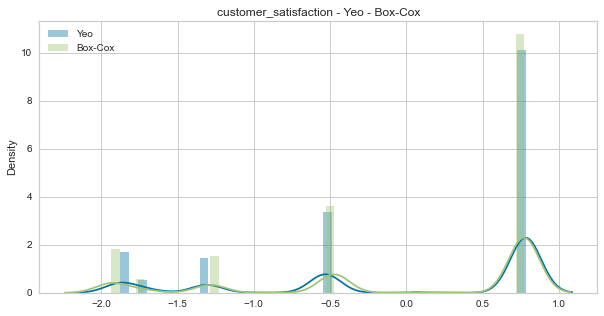

In [79]:
for i in df:
    plt.figure(figsize=(10, 5))
    if (df[i] <= 0).sum() > 0:
        plt.title(i+' - Yeo')
        sns.distplot(PowerTransformer().fit_transform(df[[i]]),
                     label='Yeo')
    else:
        plt.title(i+' - Yeo - Box-Cox')
        sns.distplot(PowerTransformer().fit_transform(df[[i]]), label='Yeo')
        sns.distplot(PowerTransformer(method='box-cox').fit_transform(df[[i]]),
                     label='Box-Cox')
        plt.legend()

On observe que les deux transformations donnent approximativement les mêmes résulats.<br />
Je décide donc d'utiliser la transformation **Yeo-Johnson**.

# 15. Standardisation des données

<u>Sauvegarde de DF avant Standardisation des données</u> :

In [80]:
df_original = df.copy()

Après analyse je décide d'utiliser la transformation **Yeo-Johnson** <br />
sur l'ensemble de mes features à l'exception de la feature '**total_of_orders**' <br />
pour laquelle j'utilise la transformation **MinMaxScaler**.

In [81]:
df[['late_delivery',
    'payment_type_score',
    'total_amout_ordered',
    'total_amout_paid',
    'average_basket',
    'day_of_order',
    'month_of_order',
    'days_since_last_order',
    'customer_satisfaction']] = PowerTransformer()\
                                .fit_transform(df[['late_delivery',
                                                   'payment_type_score',
                                                   'total_amout_ordered',
                                                   'total_amout_paid',
                                                   'average_basket',
                                                   'day_of_order',
                                                   'month_of_order',
                                                   'days_since_last_order',
                                                   'customer_satisfaction']])

In [82]:
df.total_of_orders = MinMaxScaler().fit_transform(df[['total_of_orders']])

<u>Je recrée un DataFrame avec mes valeurs transformées</u> :

In [83]:
df = pd.DataFrame(PowerTransformer()
                  .fit_transform(df.select_dtypes(exclude='object')),
                  columns=df.select_dtypes(exclude='object').columns)

In [84]:
df.head().T

,0,1,2,3,4
late_delivery,-0.13328,-0.48294,-1.42513,0.09909,-0.71296
payment_type_score,0.54211,0.54211,0.54211,0.54211,0.54211
total_of_orders,-0.17588,-0.17588,-0.17588,-0.17588,-0.17588
total_amout_ordered,0.27325,0.99626,0.37629,0.43837,0.80865
total_amout_paid,0.24411,0.94853,0.31298,0.40136,0.72714
average_basket,0.30642,1.05961,0.41317,0.47758,0.86323
day_of_order,-0.89629,0.71235,1.63212,-0.89629,1.63212
month_of_order,-0.25474,-1.72527,-0.25474,-0.92350,0.35357
days_since_last_order,1.40975,0.06681,-0.83503,-0.32868,-1.55286
customer_satisfaction,-0.88653,0.83047,0.83047,0.83047,0.83047


<u>Sauvegarde de DF après Standardisation des données</u> :

In [85]:
df_std = df.copy()

# 16. Traitement des outliers

N'ayant pas détecter de valeur aberrantes, <br />
seulement des valeurs extrêmes que je juge pertinentes,<br />
je décide de ne pas traiter les outliers.

# 17. Sauvegarde et Restauration des DataFrame

## 17.1 Sauvegarde des DataFrame

In [86]:
# pickle.dump(df, open('df_val_original', 'wb'))
# pickle.dump(df_std, open('df_val_std', 'wb'))

## 17.2 Restauration des DataFrame

In [87]:
# df = pickle.load(open('df_val_original', 'rb'))
# df_std = pickle.load(open('df_val_std', 'rb'))

# 18. Segmentation des clients

Je vais maintenant segmenter mes clients.

Je décide de commencer pour une <u>segmentation **RFM**</u>.

La méthode de <u>segmentation **RFM**</u> permet un classement<br />
des clients en fonction de leurs habitudes d'achat<br />
défini par leur :
 - **R**écence d'achat
 - **F**réquence d'achat
 - **M**ontant d'achat.

J'utiliserai différentes techniques de segmentation,<br />
comme **K-Means**, **DBScan** ou encore **Agglomerative Clustering**<br />
L'objectif sera d'obtenir des segmentations qui soient à la fois <u>cohérentes</u><br />
et <u>exploitables</u> pour les <u>équipes marketing</u>.

Pour cette raison, pour chaque segmentation client,<br />
j'évaluerai les segmentations selon les critères suivants :
 - Nombre de Clusters
 - Nombre de Clients / Cluster
 - Interprétabilité des clusters

Je répèterai ces opérations en ajoutant des features<br />
aux features RFM existantes, une à une, jusqu'à obtenir<br />
une segmentation que je jugerai satisfaisante<br />
d'un point de vue métier.

# 19. Test avec 3 features

<u>Features utilisées</u> :
- **R** --> **R**écence --> 'days_since_last_order'
- **F** --> **F**réquence --> 'total_of_orders'
- **M** --> **M**ontant --> 'total_amout_paid'

Création du DataFrame '**df3**' contenant les valeurs<br />
originales <u>non standardisées</u>, pour l'affichage<br />
des graphiques BoxPlot.

In [88]:
df3 = df_original.copy()[['days_since_last_order',
                          'total_of_orders',
                          'total_amout_paid']]

Création du DataFrame '**df3std**'<br />
contenant les valeurs <u>standardisées</u> :

In [89]:
df3std = df_std[['days_since_last_order',
                 'total_of_orders',
                 'total_amout_paid']]

<u>Je renomme les colonnes pour plus de lisibilité</u> :

In [90]:
df3.rename(columns={'days_since_last_order': 'recency',
                    'total_of_orders': 'frequency',
                    'total_amout_paid': 'amount'},
           inplace=True)
df3std.rename(columns={'days_since_last_order': 'recency',
                       'total_of_orders': 'frequency',
                       'total_amout_paid': 'amount'},
              inplace=True)

## 19.1 Coefficient de silhouette

Le **coefficient de silhouette** est <u>une mesure de<br />
qualité d'une partition d'un ensemble de données</u>.

Pour chaque point, son coefficient de silhouette<br />
est la différence entre la distance moyenne<br />
avec les points du même groupe que lui (cohésion)<br /> 
et la distance moyenne avec les points des autres<br />
groupes voisins (séparation).

Si cette différence est **négative**,<br />
le point est en moyenne plus proche du groupe voisin<br />
que du sien et il est donc <u>mal classé</u>.

A l'inverse, si cette différence est **positive**,<br />
le point est en moyenne plus proche de son groupe<br />
que du groupe voisin et il est donc <u>bien classé</u>.

Le coefficient de silhouette proprement dit est<br />
la moyenne du coefficient de silhouette pour tous les points.

J'utilise l'algorithme KMeans pour calculer le coefficient<br />
de silhouette, pour différents nombres de clusters allant de **3** à **20**.<br />
Nous analyserons ensuite la valeurs des différents coefficients<br />
de silhouette pour déterminer, à priori, le nombre optimal de clusters.<br />
Nous utiliserons également la méthode du coude via la fonction **KElbowVisualizer**.

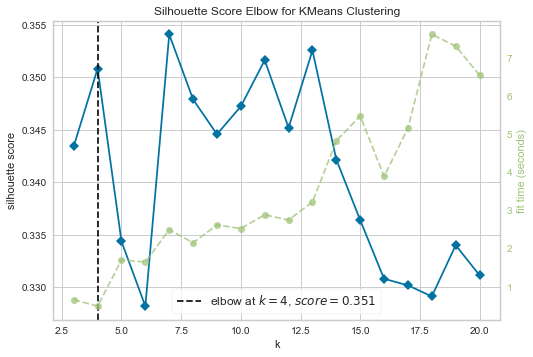

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [91]:
model = KMeans()
visualizer = KElbowVisualizer(model, 
                              k=(3,21),
                              metric='silhouette', 
                              timings=True)

visualizer.fit(df3std)
visualizer.poof()

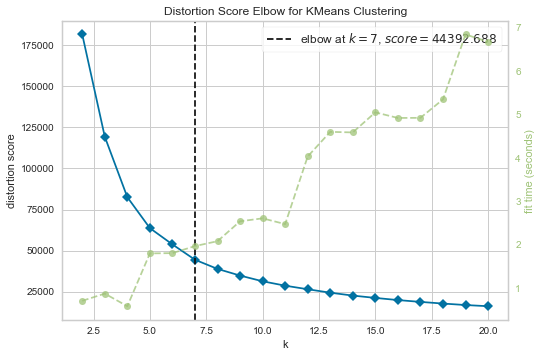

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
model = KMeans()
visualizer = KElbowVisualizer(model,
                              k=(2, 21))

visualizer.fit(df3std)
visualizer.poof()

Les valeurs du coefficient de silhouette ne varient pas<br />
significativement quel que soit la valeur de k.<br />
Cependant, on peut noter que les valeurs de k <br />
les plus optimisés sont **4**, **7**, **11** et **13**.<br />
Il peut être compliqué d'd'interpréter <u>plus de 10 clusters</u>,<br />
et je vais donc me concentrer ici sur les valeurs de k valant **4** et **7**,<br />
plus utile pour une interprétation métier.

<u>Affichons maintenant les différents clusters en fonction de leur population</u> :

Le visualiseur de silhouette affiche le coefficient de silhouette pour chaque cluster,<br />
en évaluant visuellement leur densité et leur séparation par rapport aux autres clusters. 

Le score est calculé en faisant la moyenne du coefficient de silhouette<br />
pour chaque échantillon par cluster, calculé comme la différence<br />
entre la distance moyenne intra-cluster et la distance moyenne<br />
au plus proche cluster pour chaque échantillon,<br />
normalisée par la valeur maximale.<br />
Cela donne un score entre **-1** et **+1**, où les scores proches de +1 indiquent<br />
une séparation élevée et les scores proches de **-1** indiquent<br />
que les échantillons peuvent avoir été affectés au mauvais cluster.

Dans les graphiques de **SilhouetteVisualizer**, les clusters ayant des scores<br />
plus élevés ont des silhouettes plus larges, mais les grappes qui sont moins<br />
cohésives n'atteignent pas le score moyen de toutes les clusters,<br />
qui est représenté par une ligne verticale pointillée en rouge.

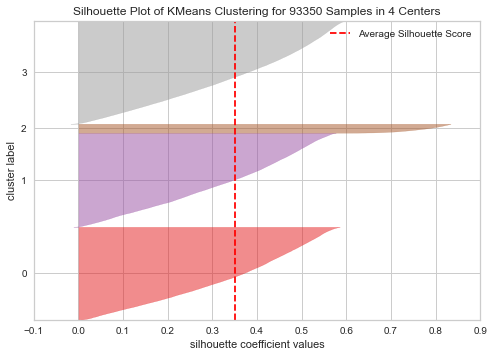

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93350 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [93]:
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df3std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

**3** des **4** clusters semblent très homogènes,<br />
aussi bien en population qu'en fonction de leur coefficient de silhouette.

Un des clusters se démarque cependant par une population beaucoup plus faible<br />
mais avec un coefficient de silhouette nettement plus élevé.<br />
Ce groupe de client semble se démarquer nettement du reste de la population.

Enfin, aucun des clusters n'a d'échantillon avec un coefficient de silhouette inférieur à 0.

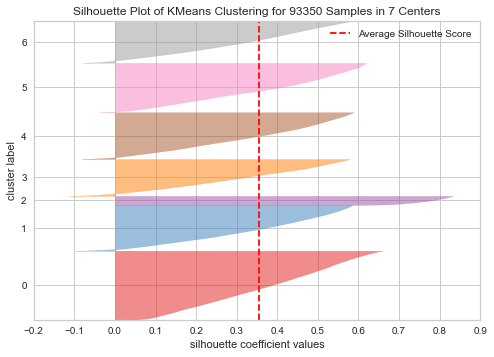

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93350 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [94]:
model = KMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df3std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Ici les différents clusters sont un peu moins homogènes qu'avec seulement 4 clusters.<br />
Quelques échantillons appartenant à différents cluster ont un coefficient<br />
de silhouette inférieur à 0 et peuvent aller jusqu'à -0.1.<br />
On observe toujours notre cluster à faible population<br />
et aux taux de coefficient de silhouette élevé.

A ce stade, avec 3 features, il me semble plus pertinent<br />
de partitionner nos clients en 4 clusters.

Quel que soit le nombre de cluster choisi,<br />
on remarque qu'un cluster reste identique.<br />
Il contient moins de clients que n'importe quel autre cluster <br />
mais possède une bonne valeur de coefficient de silhouette.

## 19.2 K-Means

Utilisation de K-Means pour calculer 4, 7, 11 et 13 clusters,<br />
les valeurs optimales en nombre de clusters d'après le **coefficient de silhouette**.

In [95]:
for i in [4,7,11,13]:
    print('n_clusters =',i)
    df3['cluster_number_for_'+str(i)+'_clusters'] =\
    pd.DataFrame(data=KMeans(n_clusters=i).fit(df3std).labels_,
                 index=df3.index)

n_clusters = 4
n_clusters = 7
n_clusters = 11
n_clusters = 13


In [96]:
df3.head(3).T

,0,1,2
recency,470.00000,228.00000,101.00000
frequency,1.00000,1.00000,1.00000
amount,146.87000,335.48000,157.73000
cluster_number_for_4_clusters,0.00000,0.00000,1.00000
cluster_number_for_7_clusters,2.00000,5.00000,3.00000
cluster_number_for_11_clusters,8.00000,7.00000,3.00000
cluster_number_for_13_clusters,10.00000,11.00000,4.00000


## 19.3 PCA

<u>J'applique une Analyse en Composante Principale à mon jeu de donnée <br />
en le ramenant en 2 dimensions afin de pouvoir visualiser graphiquement<br />
les différents clusters</u> :

In [97]:
pca = PCA(n_components=2)
pca.fit(df3std)
print('Variance explained by the two principals components:',
      pca.explained_variance_ratio_.cumsum()[-1])
X_pca = pca.transform(df3std)

Variance explained by the two principals components: 0.7437380791066505


<u>Affichage des clusters en fonction du nombre total de clusters</u> : 

-----------------------------
Number of clusters: 4
Cluster n°0 -- number of customers: 29182
Cluster n°1 -- number of customers: 32288
Cluster n°2 -- number of customers: 2801
Cluster n°3 -- number of customers: 29079
-----------------------------
-----------------------------
Number of clusters: 7
Cluster n°0 -- number of customers: 14803
Cluster n°1 -- number of customers: 2801
Cluster n°2 -- number of customers: 14069
Cluster n°3 -- number of customers: 15579
Cluster n°4 -- number of customers: 13431
Cluster n°5 -- number of customers: 11256
Cluster n°6 -- number of customers: 21411
-----------------------------
-----------------------------
Number of clusters: 11
Cluster n°0 -- number of customers: 6684
Cluster n°1 -- number of customers: 7955
Cluster n°2 -- number of customers: 2801
Cluster n°3 -- number of customers: 9776
Cluster n°4 -- number of customers: 6993
Cluster n°5 -- number of customers: 11559
Cluster n°6 -- number of customers: 11039
Cluster n°7 -- number of customers

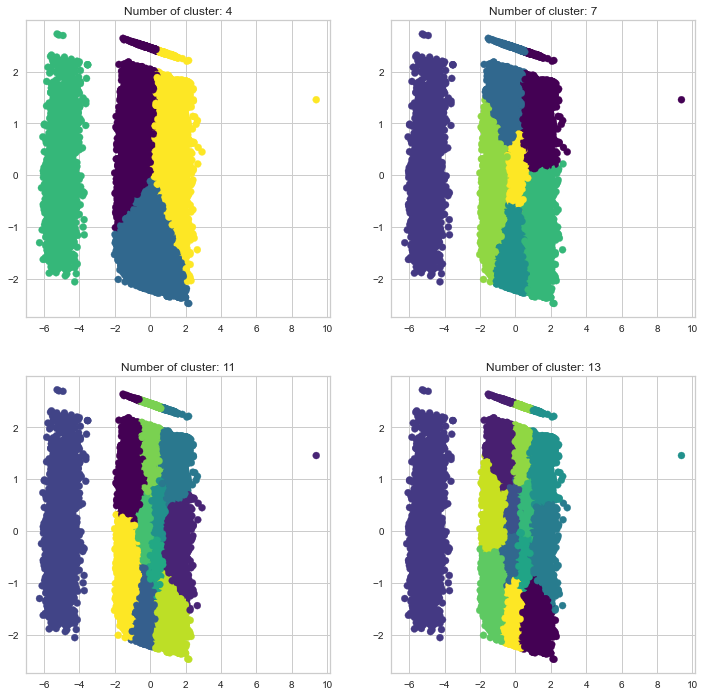

In [98]:
plt.figure(figsize=(12, 12))
nbColumns = 2
nbRows = len(df3.columns[3:])//nbColumns +\
        (len(df3.columns[3:])%nbColumns > 0)
for i,j in enumerate(df3.columns[3:]):
    # Extract the number of clusters
    clusterNumber = int(re.sub('cluster_number_for_',
                            '',
                            re.sub('\_clusters$',
                                    '',
                                    j)))
    # Plot Clusters
    plt.subplot(nbRows,nbColumns,i+1)
    plt.scatter(X_pca[:, 0],
                X_pca[:, 1],
                c=df3[j],
                cmap="viridis")
    plt.title(f'Number of cluster: {clusterNumber}')
    print('-----------------------------')
    print('Number of clusters:',clusterNumber)
    for k,l in enumerate(df3[j].value_counts().sort_index()):
        print(f'Cluster n°{k} -- number of customers: {l}')
    print('-----------------------------')

<u>Affichage du nombre de Client/Cluster en fonction du nombre de clusters total</u> :

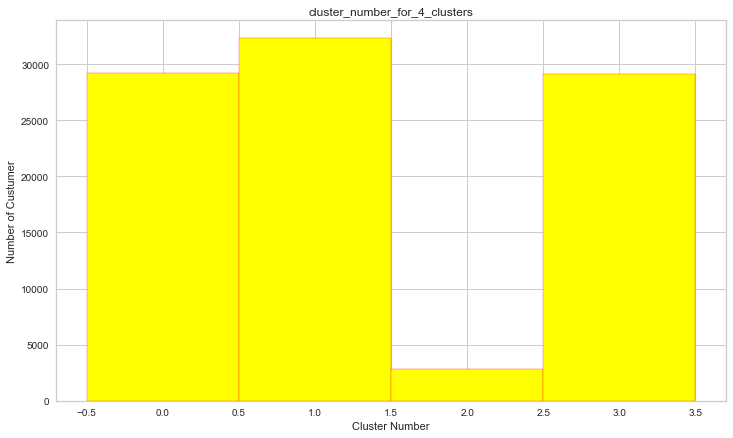

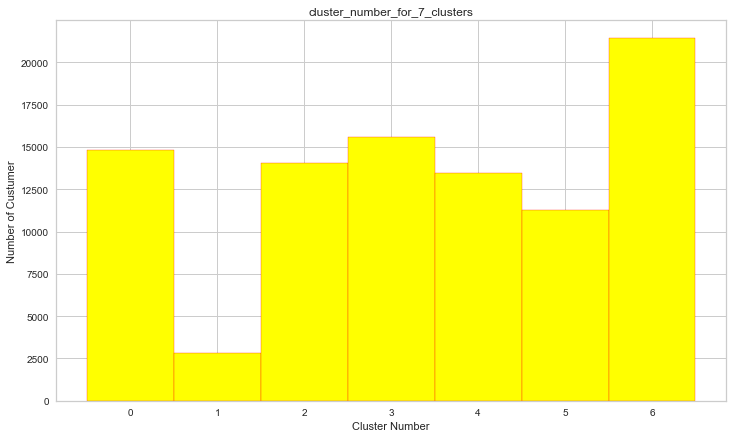

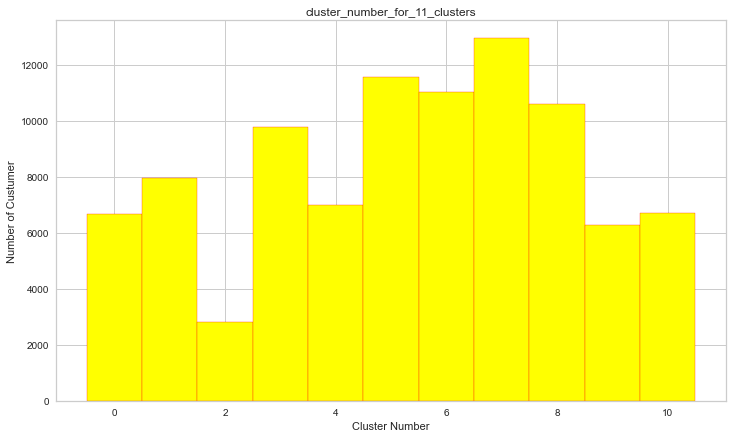

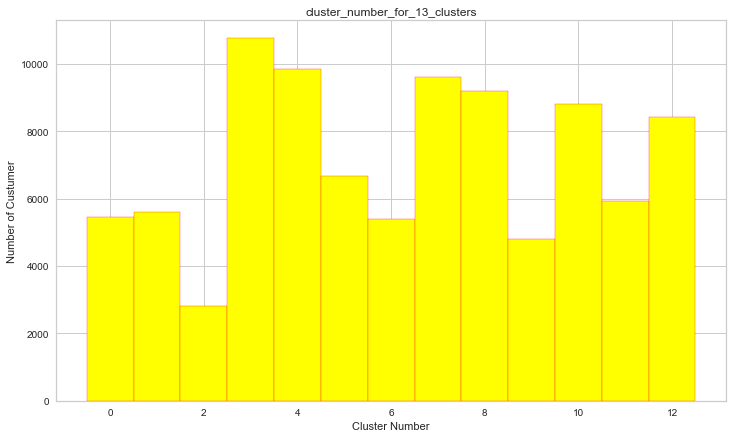

In [99]:
for i,j in enumerate(df3.iloc[:,3:]):
    clusterNumber = int(re.sub('cluster_number_for_',
                            '',
                            re.sub('\_clusters$',
                                    '',
                                    j)))
    plt.figure(figsize=(12,7))
    plt.hist(df3[j],
             range=(0, clusterNumber),
             bins=clusterNumber,
             color='yellow', 
             edgecolor = 'red',
             align='left')
    plt.title(j)
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Custumer')

## 19.4 Graphique BoxPlot

J'affiche pour chaque feature,<br />
les différents clusters sous forme de boxplot<br />
en fonction du nombre de clusters total.

Cette visualisation doit nous permetre de comprendre<br />
et d'interpeter les profils des différents clients.

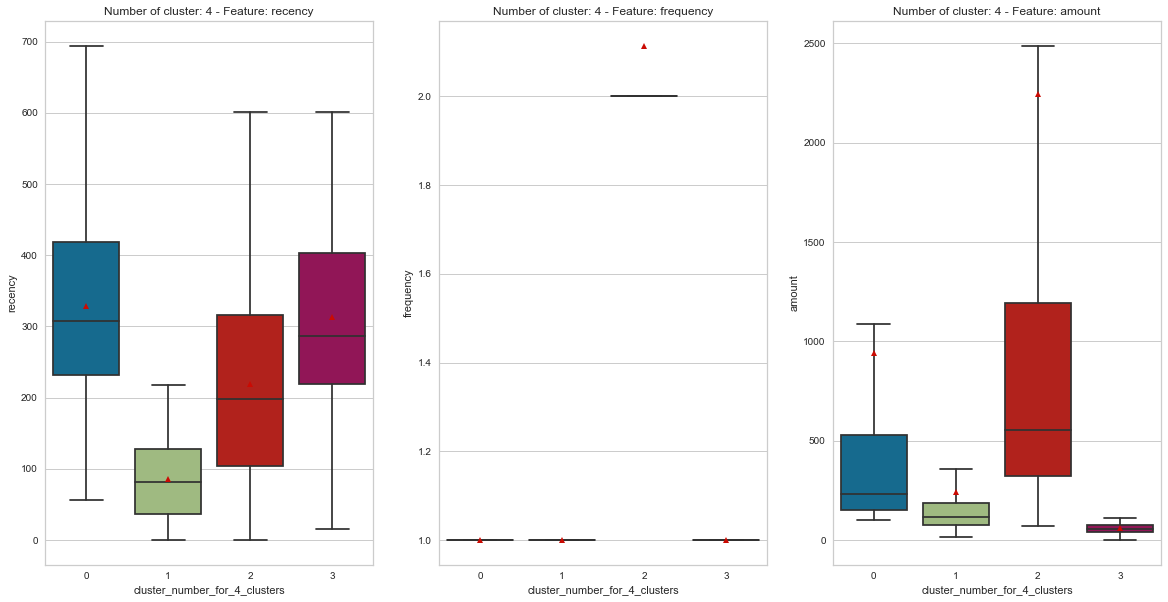

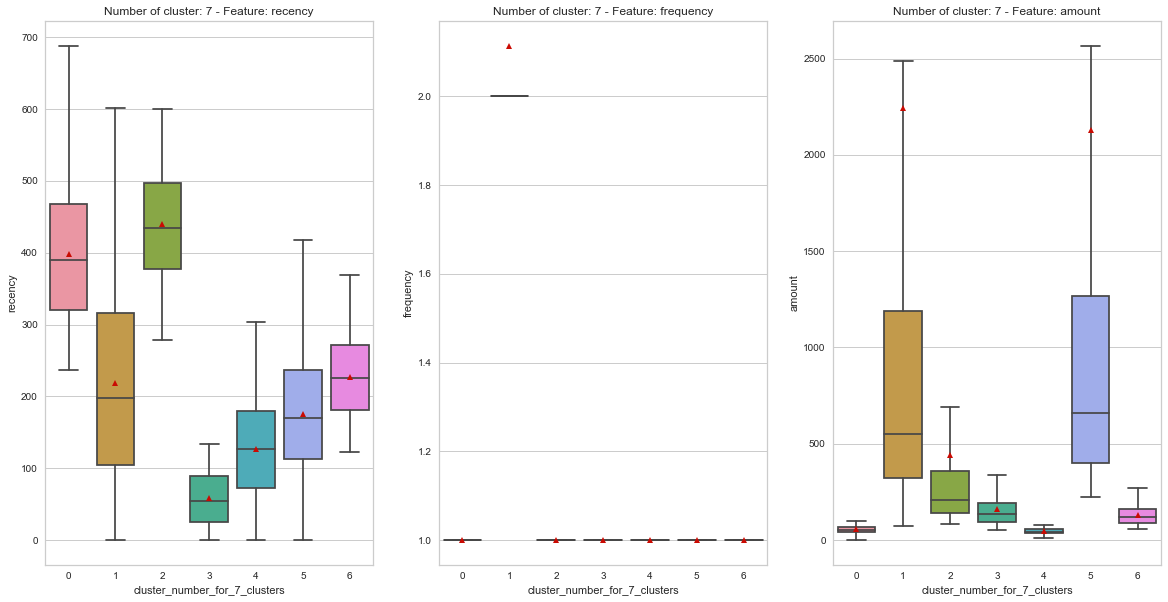

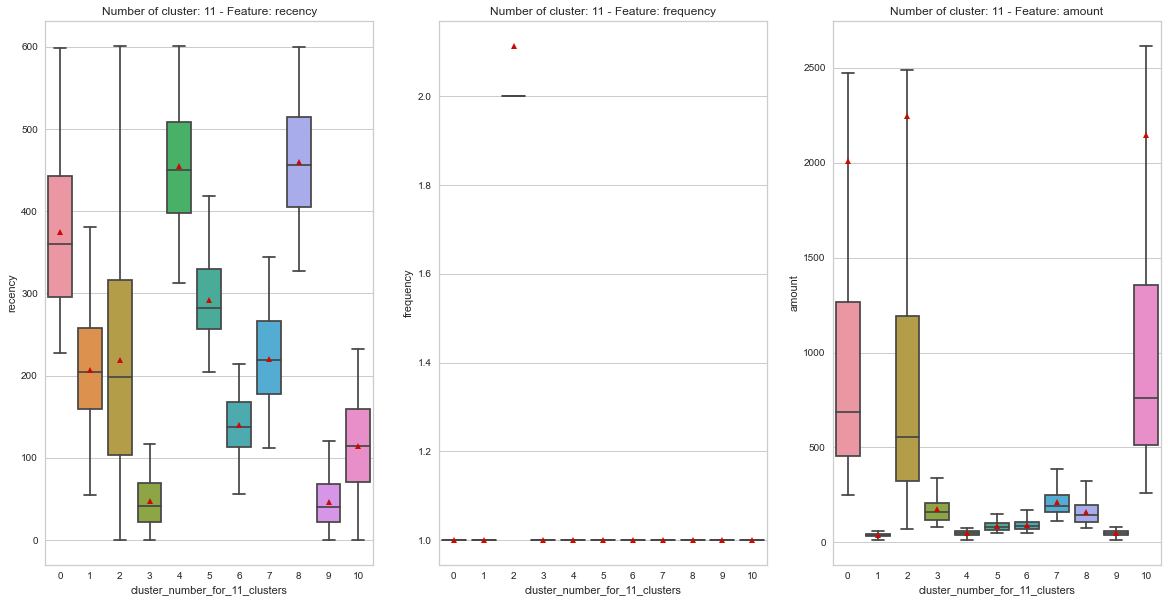

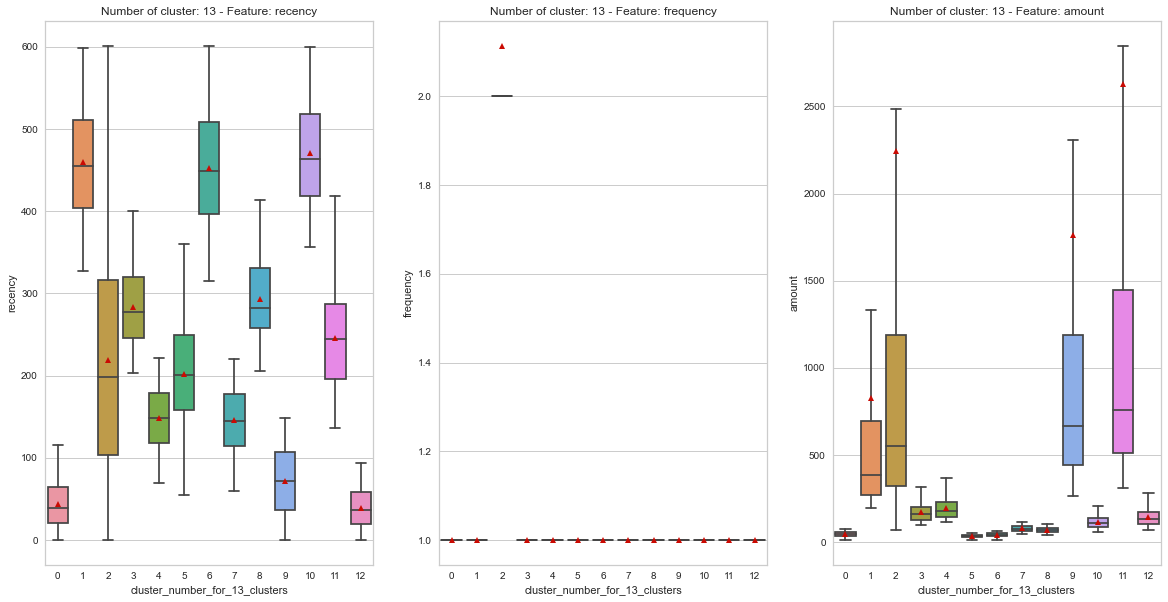

In [100]:
for i,j in enumerate(df3.iloc[:,3:]):
    clusterNumber = int(re.sub('cluster_number_for_',
                            '',
                            re.sub('\_clusters$',
                                    '',
                                    j)))
    plt.figure(figsize=(20,10))
    for k in range(3):
        plt.subplot(1,3,k+1)
        plt.title(f'Number of cluster: {clusterNumber} - Feature: {df3.columns[k]}')
        sns.boxplot(x=df3.iloc[:,i+3],
                    y=df3.iloc[:,k],
                    showfliers = False,
                    showmeans=True)

<u>Interpretation lorsque le jeu de donnée est divisé en</u> :
 - <u>4 clusters</u> :
  - **Cluster n°0** :
    - Regroupe les clients qui ont acheté 1 seule fois,<br />
      et uniquement des petits montants,<br />
      indépendamment de leur récence d'achat.
  - **Cluster n°1** :
    - Regroupe les clients qui ont acheté plusieurs fois<br />
      indépendamment de leur récence d'achat et de la valeur de leurs achats.<br />
      Inclus également les clients dont le montant total d'achat<br />
      est le plus élevé. <u>Ils représentent les meilleurs clients</u>.
  - **Cluster n°2** :
    - Regroupe globalement les clients les plus anciens,<br />
      qui ont acheté qu'une seule fois pour des montants moyens<br />
      comparés aux autres clusters.
  - **Cluster n°3** :
    - Regroupe les clients relativement récents,<br />
      qui ont commandé qu'une seule fois pour<br />
      des montants relativement faibles.
 - <u>7 clusters</u> :
  - **Cluster n°0** :
    - Regroupe les clients relativement récents,<br />
      qui ont commandé qu'une seule fois<br />
      et pour un très faible montant.
  - **Cluster n°1** :
    - Regroupe les clients parmi les plus anciens,<br />
      qui ont commandé une seule fois,<br />
      pour des montants faibles à moyens.
  - **Cluster n°2** :
    - Regroupe les clients qui ont commandé plusieurs fois,<br />
      sans distinction de récence ou de montant total commandé.
  - **Cluster n°3** :
    - Regroupe les clients les plus récents,<br />
      qui ont commandé qu'une seule fois<br />
      pour un montant relativement faible.
  - **Cluster n°4** :
    - Relativement semblable au cluster 1<br />
      mais pour des montants d'achats beaucoup plus faibles.
  - **Cluster n°5** :
    - Assez semblable au cluster 2 à la différence<br />
      qu'il ne regroupe que les clients ayant effectués des achats uniques.
  - **Cluster n°6** :
    - Regroupe les clients ne comptant ni parmi les plus récent,<br />
      ni parmi les plus anciens, qui ont commandé qu'une seule fois<br />
      pour des montants relativement faibles.
 - <u>11 et 13 clusters</u> :
   - L'interprétabilité est plus complexe, et dans l'optique de communiquer<br />
     des informations claires, et facilement exploitable aux équipes marketing,<br />
     je décide de ne pas retenir ces 2 clusterisations.

## 19.5 Diagramme de Kiviat 

Le **diagramme de Kiviat** nous permet de visualiser rapidement<br />
et efficacement le profil client de chaque cluster.<br />
Le graphique affiche les valeurs moyennes, normalisés entre 0 et 1<br />
de chaque feature, pour chaque cluster.<br />
Cela permet de déterminer d'un seul coup le profil type<br />
de chaque groupe de client que KMeans a identifié.

In [101]:
df3_kiviat = df3.copy()
df3_kiviat[['recency', 
            'frequency', 
            'amount']] = MinMaxScaler()\
                         .fit_transform(PowerTransformer()\
                                        .fit_transform(df3_kiviat[['recency',
                                                                   'frequency',
                                                                   'amount']]))

<u>Je ne conserve que le nombre de *clusters optimal*<br />
pour l'affichage des **Diagrammes de Kiviat**</u> :

In [102]:
df3_kiviat = df3_kiviat[['recency',
                         'frequency',
                         'amount',
                         'cluster_number_for_4_clusters']]

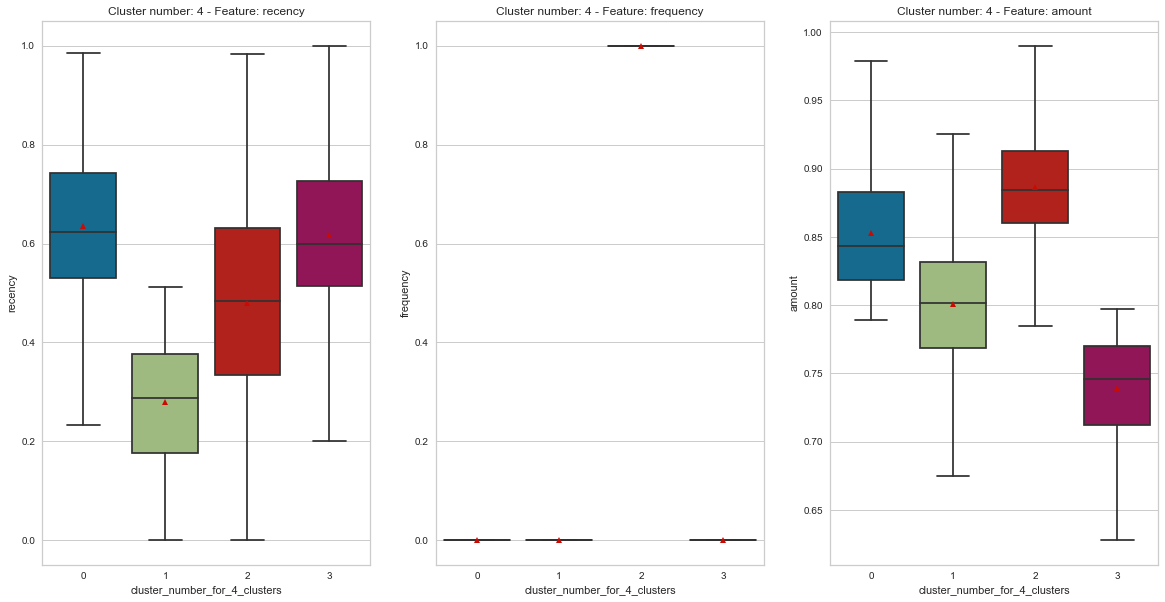

In [103]:
plt.figure(figsize=(20,10))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.title(f'Cluster number: 4 - Feature: {df3_kiviat.columns[k]}')
    sns.boxplot(x=df3_kiviat.iloc[:,-1],
                y=df3_kiviat.iloc[:,k],
                showfliers = False,
                showmeans=True)

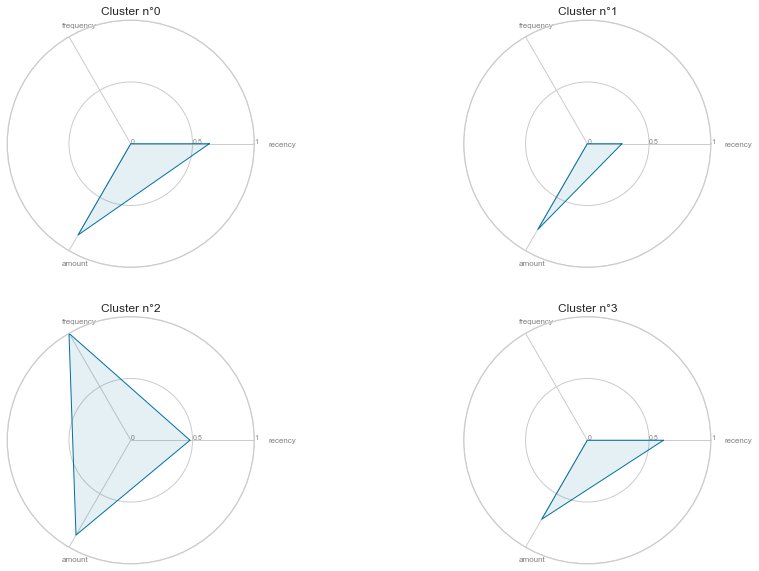

In [104]:
nbColumns = 2
nbRows = df3_kiviat.iloc[:,-1].nunique()//nbColumns +\
         (df3_kiviat.iloc[:,-1].nunique()%nbColumns > 0)
colClusters = df3_kiviat.columns[-1]
plt.figure(figsize=(15,5*nbRows))
for i in sorted(df3_kiviat.iloc[:,-1].unique()):
    # number of variable
    categories=list(df3_kiviat)[:-1]
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values=df3_kiviat[df3_kiviat[colClusters] == i]\
           .drop(colClusters, axis=1)\
           .mean().values.tolist()
    values += values[:1]
   
    # What will be the angle of each axis in the plot?
    # (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
   
    # Initialise the spider plot
    ax = plt.subplot(nbRows,nbColumns,i+1, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1],
               categories,
               color='grey',
               size=8,
               ha='left')

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,0.5,1], ["0","0.5","1"],
               color="grey",
               size=7)
    plt.ylim(0,1)

    # Plot data
    ax.plot(angles,
            values,
            linewidth=1,
            linestyle='solid')
    
    # Fill area
    ax.fill(angles,
            values,
            'b',
            alpha=0.1)
    
    plt.title(f'Cluster n°{i}')

## 19.6 DBSCAN

DBSCAN est un algorithme de clustering qui s’appuie sur la densité <br />
estimée des clusters pour effectuer le partitionnement.

L'algorithme DBSCAN utilise 2 paramètres : 
 - La distance **epsilon**
 - Le nombre minimum de points **MinPts** devant se trouver <br />
   dans un rayon **epsilon** pour que ces points soient considérés<br />
   comme un cluster. 
   
Les paramètres d'entrées sont donc une estimation de la densité<br />
de points des clusters.<br />
L'idée de base de l'algorithme est ensuite, pour un point donné,<br />
de récupérer son **epsilon-voisinage** et de vérifier qu'il contient bien<br />
**MinPts** points ou plus.<br />
Ce point est alors considéré comme faisant partie d'un cluster.<br />
On parcourt ensuite l'**epsilon-voisinage** de proche en proche afin<br />
de trouver l'ensemble des points du cluster.

Contrairement à KMeans, ici nous ne choisissons pas<br />
à l'avance le nombre de Cluster.

<u>Suppression des colonnes contenant les clusters K-Means dans **df3std** et **df3**</u> :

In [105]:
df3std = df3std.iloc[:,:3]
df3 = df3.iloc[:,:3]

<u>Test de l'algorithme **DBSCAN** pour **EPS allant de 0.1 à 1.5** par pas de **0.1**</u> :

In [106]:
coeffSilhouette = []
numberOfCluster = []
for i in range(1,16):
    print('eps =',i/10)
    db3=DBSCAN(eps=i/10, min_samples=10,).fit(df3std)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db3.labels_)) - (1 if -1 in db3.labels_ else 0)
    
    coeffSilhouette.append(silhouette_score(df3std, db3.labels_))
    numberOfCluster.append(n_clusters_)

    # I assign the calculated labels in a new column of the DataFrame df3
    # for future analysis of the number of customers per cluster.
    df3['cluster_for_EPS_'+str(i/10)] =\
    pd.DataFrame(data=db3.labels_,
                 index=df3.index)

eps = 0.1
eps = 0.2
eps = 0.3
eps = 0.4
eps = 0.5
eps = 0.6
eps = 0.7
eps = 0.8
eps = 0.9
eps = 1.0
eps = 1.1
eps = 1.2
eps = 1.3
eps = 1.4
eps = 1.5


In [107]:
# Saving the coeffSilhouette and numberOfCluster Lists
pickle.dump(coeffSilhouette, open('dbscan_coeffSilhouette_3f', 'wb'))
pickle.dump(numberOfCluster, open('dbscan_numberOfCluster_3f', 'wb'))
# Restoration of the coeffSilhouette and numberOfCluster lists
# coeffSilhouette = pickle.load(open('dbscan_coeffSilhouette_3f', 'rb'))
# numberOfCluster = pickle.load(open('dbscan_numberOfCluster_3f', 'rb'))

<u>Pour chaque **EPS** testé, affichage du nombre de cluster et du coefficient de silhouette </u> :

Text(0.5, 1.0, 'Number of Clusters according to EPS value')

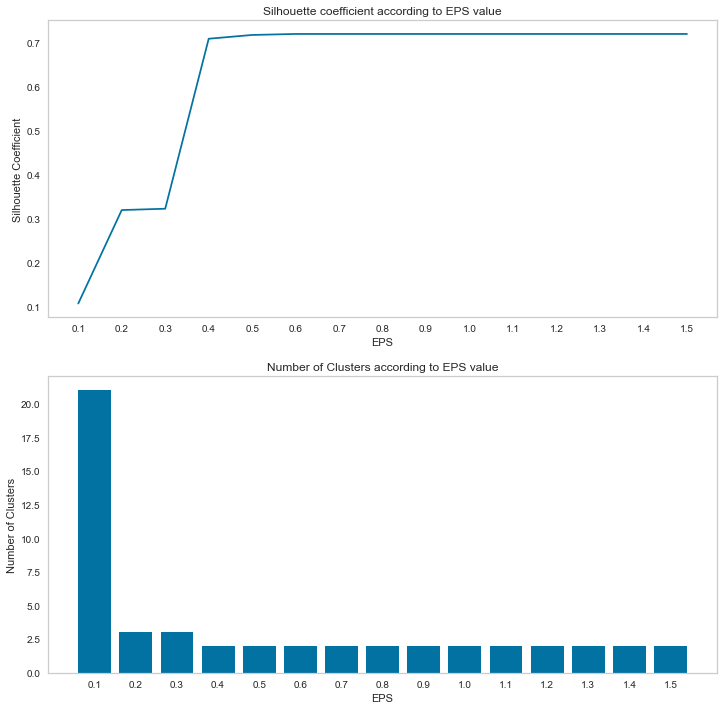

In [108]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(list(map(str, np.linspace(1,15,15,dtype='int')/10)), coeffSilhouette)
plt.grid()
plt.xlabel('EPS')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette coefficient according to EPS value')
plt.subplot(212)
plt.bar(list(map(str, np.linspace(1,15,15,dtype='int')/10)), numberOfCluster)
plt.grid()
plt.xlabel('EPS')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters according to EPS value')

<u>Affichage du nombre de clients / cluster en fonction de **EPS**</u> :

In [109]:
for i,j in enumerate(df3.columns[3:]):
    print('-----------------------------')
    print('Number of Clusters for EPS =',
          (i+1)/10,
          ':',
          df3[j].nunique())
    for index, value in df3[j].value_counts().sort_index().items():
        print(f'Cluster n°{index} -- Number of customers: {value}')
    print('-----------------------------')

-----------------------------
Number of Clusters for EPS = 0.1 : 22
Cluster n°-1 -- Number of customers: 828
Cluster n°0 -- Number of customers: 89977
Cluster n°1 -- Number of customers: 10
Cluster n°2 -- Number of customers: 175
Cluster n°3 -- Number of customers: 1929
Cluster n°4 -- Number of customers: 15
Cluster n°5 -- Number of customers: 14
Cluster n°6 -- Number of customers: 205
Cluster n°7 -- Number of customers: 35
Cluster n°8 -- Number of customers: 18
Cluster n°9 -- Number of customers: 11
Cluster n°10 -- Number of customers: 8
Cluster n°11 -- Number of customers: 28
Cluster n°12 -- Number of customers: 11
Cluster n°13 -- Number of customers: 11
Cluster n°14 -- Number of customers: 10
Cluster n°15 -- Number of customers: 10
Cluster n°16 -- Number of customers: 14
Cluster n°17 -- Number of customers: 11
Cluster n°18 -- Number of customers: 10
Cluster n°19 -- Number of customers: 10
Cluster n°20 -- Number of customers: 10
-----------------------------
-------------------------

L'utilisation de **DBSCAN** dans notre cas est <u>inexploitable</u><br />
pour une utilisation métier car les clusters ne sont pas équilibrés.

Nous avons par exemple des clusters contenants **une dizaine de clients**<br />
alors qu'un autre cluster en contient **89977**.

## 19.7 Agglomerative Clustering - Dendrogram

Le **dendrogramme** est une arborescence qui affiche les groupes formés<br />
par le regroupement des observations à chaque étape et leurs niveaux de similarité.<br />
Le niveau de **similarité** est mesuré le long de l'**axe vertical**<br />
et les **différentes observations** sont répertoriées le long de l'**axe horizontal**.

### 19.7.1 Test avec 10 000 données

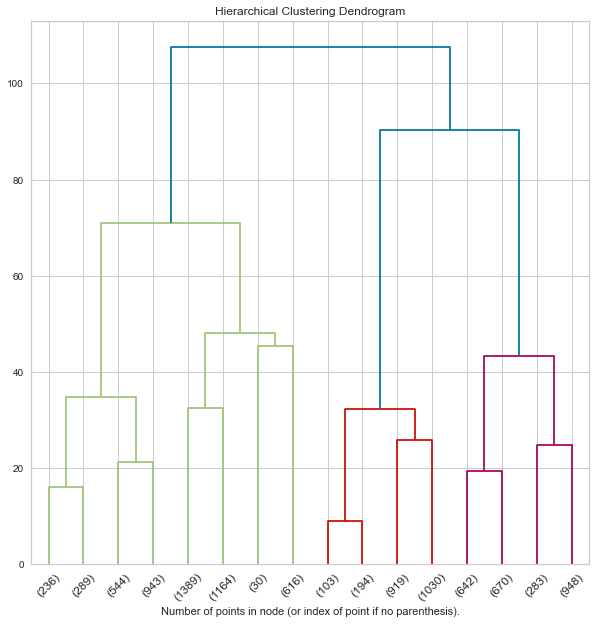

In [110]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# I select my data
X = df3std.iloc[:10000,:]

model = model.fit(X)
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.xticks(rotation=45)
plt.show()

<u>Plusieurs remarques sont à prendre en compte sur l'utilisation de cette méthode</u> :
- La méthode est lourde en calcul
 - Il est nécessaire dans notre cas de réaliser le test<br />
   sur une partie de notre jeu de donnée,<br />
   malheureusement le clustering risque d'être totalement différent<br />
   si nous le réalisons sur l'ensemble du jeu de donnée
- Les clusters ne sont pas équilibrés et s'étalent, dans notre exemple,<br />
  de 30 individus à 1389 individus, ce qui n'est pas exploitable<br />
  dans une problématique métier.

# 20. Test avec 4 features

<u>Features utilisées</u> :
- **R** --> **R**écence --> 'days_since_last_order'
- **F** --> **F**réquence --> 'total_of_orders'
- **M** --> **M**ontant --> 'total_amout_paid'
- **S** --> **S**atisfaction --> 'customer_satisfaction'

Création du DataFrame '**df4**' contenant les valeurs<br />
originales <u>non standardisées</u>, pour l'affichage<br />
des graphiques BoxPlot.

In [111]:
df4 = df_original.copy()[['days_since_last_order',
                          'total_of_orders',
                          'total_amout_paid',
                          'customer_satisfaction']]

Création du DataFrame '**df4std**'<br />
contenant les valeurs <u>standardisées</u> :

In [112]:
df4std = df_std[['days_since_last_order',
                 'total_of_orders',
                 'total_amout_paid',
                 'customer_satisfaction']]

<u>Je renomme les colonnes pour plus de lisibilité</u> :

In [113]:
df4.rename(columns={'days_since_last_order': 'recency',
                    'total_of_orders': 'frequency',
                    'total_amout_paid': 'amount',
                    'customer_satisfaction': 'satisfaction'},
           inplace=True)
df4std.rename(columns={'days_since_last_order': 'recency',
                       'total_of_orders': 'frequency',
                       'total_amout_paid': 'amount',
                       'customer_satisfaction': 'satisfaction'},
              inplace=True)

## 20.1 Coefficient de silhouette

Le **coefficient de silhouette** est <u>une mesure de<br />
qualité d'une partition d'un ensemble de données</u>.

Pour chaque point, son coefficient de silhouette<br />
est la différence entre la distance moyenne<br />
avec les points du même groupe que lui (cohésion)<br /> 
et la distance moyenne avec les points des autres<br />
groupes voisins (séparation).

Si cette différence est **négative**,<br />
le point est en moyenne plus proche du groupe voisin<br />
que du sien et il est donc <u>mal classé</u>.

A l'inverse, si cette différence est **positive**,<br />
le point est en moyenne plus proche de son groupe<br />
que du groupe voisin et il est donc <u>bien classé</u>.

Le coefficient de silhouette proprement dit est<br />
la moyenne du coefficient de silhouette pour tous les points.

J'utilise l'algorithme KMeans pour calculer le coefficient <br />
de silhouette, pour différents nombres de clusters allant de **3** à **20**.<br />
Nous analyserons ensuite la valeur des différents coefficient<br />
de silhouette pour déterminer, à priori, le nombre optimal de cluster.<br />
Nous utiliserons également la méthode du coude via la fonction **KElbowVisualizer**.

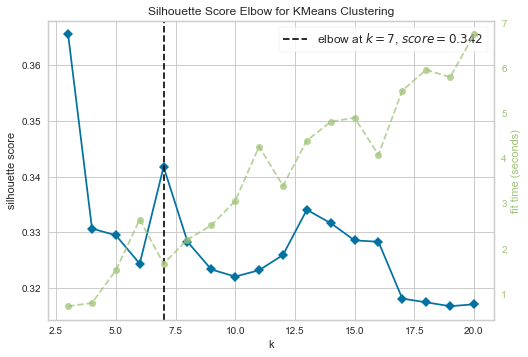

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [114]:
model = KMeans()
visualizer = KElbowVisualizer(model, 
                              k=(3,21),
                              metric='silhouette', 
                              timings=True)

visualizer.fit(df4std)
visualizer.poof()

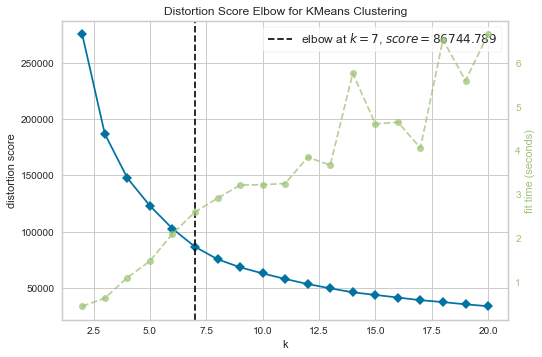

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [115]:
model = KMeans()
visualizer = KElbowVisualizer(model,
                              k=(2, 21))

visualizer.fit(df4std)
visualizer.poof()

Les valeurs du coefficient de silhouette ne varient pas<br />
significativement quel que soit la valeur de k.<br />
Cependant, on peut noter que les valeurs de k <br />
les plus optimisés sont **3** et **7**.

<u>Affichons maintenant les différents clusters en fonction de leur population</u> :

Le visualiseur de silhouette affiche le coefficient de silhouette pour chaque cluster,<br />
en évaluant visuellement leur densité et leur séparation par rapport aux autres clusters. 

Le score est calculé en faisant la moyenne du coefficient de silhouette<br />
pour chaque échantillon par cluster, calculé comme la différence<br />
entre la distance moyenne intra-cluster et la distance moyenne<br />
au plus proche cluster pour chaque échantillon,<br />
normalisée par la valeur maximale.<br />
Cela donne un score entre **-1** et **+1**, où les scores proches de +1 indiquent<br />
une séparation élevée et les scores proches de **-1** indiquent<br />
que les échantillons peuvent avoir été affectés au mauvais cluster.

Dans les graphiques de **SilhouetteVisualizer**, les clusters ayant des scores<br />
plus élevés ont des silhouettes plus larges, mais les grappes qui sont moins<br />
cohésives n'atteignent pas le score moyen de toutes les cluster,<br />
qui est représenté par une ligne verticale pointillée en rouge.

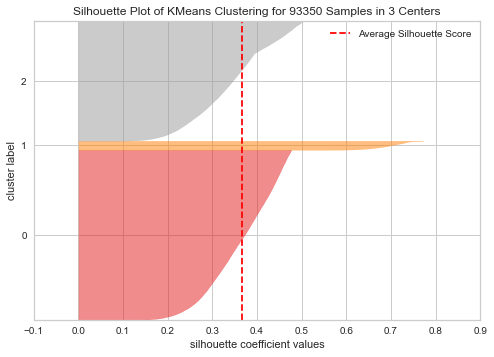

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93350 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [116]:
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df4std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

**3** des **4** clusters semblent assez homogènes,<br />
aussi bien en population qu'en fonction de leur coefficient de silhouette.

Un des clusters se démarque cependant par une population beaucoup plus faible<br />
mais avec un coefficient de silhouette nettement plus élevé.<br />
Ce groupe de client semble se démarquer nettement du reste de la population.

Enfin, aucun des clusters n'a d'échantillon avec un coefficient de silhouette inférieur à 0.

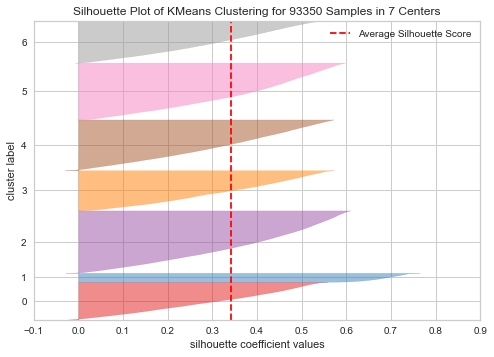

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93350 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [117]:
model = KMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df4std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Ici aussi les différents clusters semblent assez homogènes.<br />
Quelques échantillons appartenant à différents clusters ont un coefficient<br />
de silhouette inférieur à 0 et ne semble pas aller au-delà de -0.05.<br />
On observe toujours notre cluster à faible population<br />
et aux taux de coefficient de silhouette élevé.

A ce stade, avec 4 features, il m'est difficile de déterminer<br />
le nombre de clusters optimal autrement que par le score<br />
de silhouette globale qui favorise une clusterisation à **3 clusters**.

Quel que soit le nombre de clusters choisi,<br />
on remarque qu'un cluster reste identique.<br />
Il contient moins de clients que n'importe quel autre cluster <br />
mais possède une bonne valeur de coefficient de silhouette.

## 20.2 K-Means

Utilisation de K-Means pour calculer 3 et 7 clusters,<br />
les valeurs optimales en nombre de clusters d'après<br />
le **coefficient de silhouette**.

In [118]:
for i in [3, 7]:
    print('n_clusters =', i)
    df4['cluster_number_for_'+str(i)+'_clusters'] =\
        pd.DataFrame(data=KMeans(n_clusters=i).fit(df4std).labels_,
                     index=df4.index)

n_clusters = 3
n_clusters = 7


In [119]:
df4.head(3).T

,0,1,2
recency,470.00000,228.00000,101.00000
frequency,1.00000,1.00000,1.00000
amount,146.87000,335.48000,157.73000
satisfaction,4.00000,5.00000,5.00000
cluster_number_for_3_clusters,0.00000,1.00000,1.00000
cluster_number_for_7_clusters,1.00000,6.00000,2.00000


## 20.3 PCA

<u>J'applique une Analyse en Composante Principale à mon jeu de donnée <br />
en le ramenant en 2 dimensions afin de pouvoir visualiser graphiquement<br />
les différents clusters</u> :

In [120]:
pca = PCA(n_components=2)
pca.fit(df4std)
print('Variance explained by the two principals components:',
      pca.explained_variance_ratio_.cumsum()[-1])
X_pca = pca.transform(df4std)

Variance explained by the two principals components: 0.5679170405300833


<u>Affichage des clusters en fonction du nombre total de clusters</u> : 

-----------------------------
Number of clusters: 3
Cluster n°0 -- number of customers: 37454
Cluster n°1 -- number of customers: 53095
Cluster n°2 -- number of customers: 2801
-----------------------------
-----------------------------
Number of clusters: 7
Cluster n°0 -- number of customers: 15868
Cluster n°1 -- number of customers: 12734
Cluster n°2 -- number of customers: 19582
Cluster n°3 -- number of customers: 2801
Cluster n°4 -- number of customers: 12886
Cluster n°5 -- number of customers: 11825
Cluster n°6 -- number of customers: 17654
-----------------------------


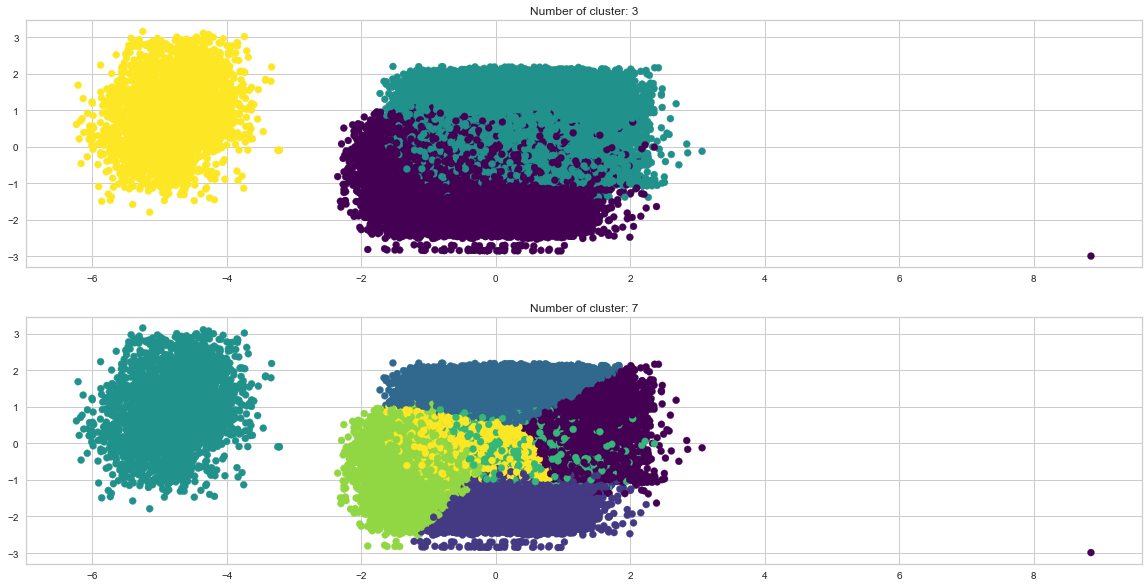

In [121]:
plt.figure(figsize=(20, 10))
nbColumns = 1
nbRows = len(df4.columns[4:])//nbColumns +\
        (len(df4.columns[4:])%nbColumns > 0)
for i,j in enumerate(df4.columns[4:]):
    # Extract the number of clusters
    clusterNumber = int(re.sub('cluster_number_for_',
                            '',
                            re.sub('\_clusters$',
                                    '',
                                    j)))
    # Plot Clusters
    plt.subplot(nbRows,nbColumns,i+1)
    plt.scatter(X_pca[:, 0],
                X_pca[:, 1],
                c=df4[j],
                cmap="viridis")
    plt.title(f'Number of cluster: {clusterNumber}')
    print('-----------------------------')
    print('Number of clusters:',clusterNumber)
    for k,l in enumerate(df4[j].value_counts().sort_index()):
        print(f'Cluster n°{k} -- number of customers: {l}')
    print('-----------------------------')

<u>Affichage du nombre de Client/Cluster en fonction du nombre de cluster total</u> :

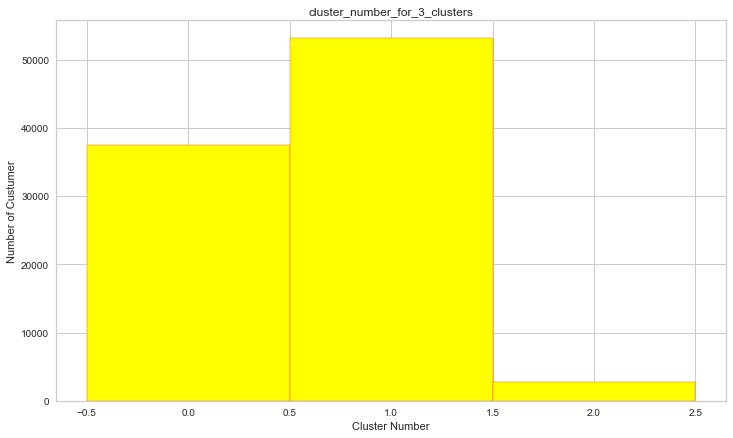

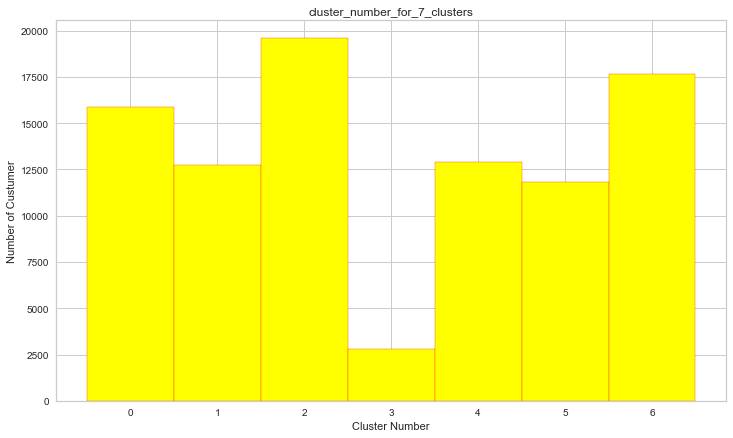

In [122]:
for i,j in enumerate(df4.iloc[:,4:]):
    clusterNumber = int(re.sub('cluster_number_for_',
                            '',
                            re.sub('\_clusters$',
                                    '',
                                    j)))
    plt.figure(figsize=(12,7))
    plt.hist(df4[j],
             range=(0, clusterNumber),
             bins=clusterNumber,
             color='yellow', 
             edgecolor = 'red',
             align='left')
    plt.title(j)
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Custumer')

## 20.4 Graphique BoxPlot

J'affiche pour chaque feature,<br />
les différents clusters sous forme de boxplot<br />
en fonction du nombre de clusters total.

Cette visualisation doit nous permettre de comprendre<br />
et d'interpréter les profils des différents clients.

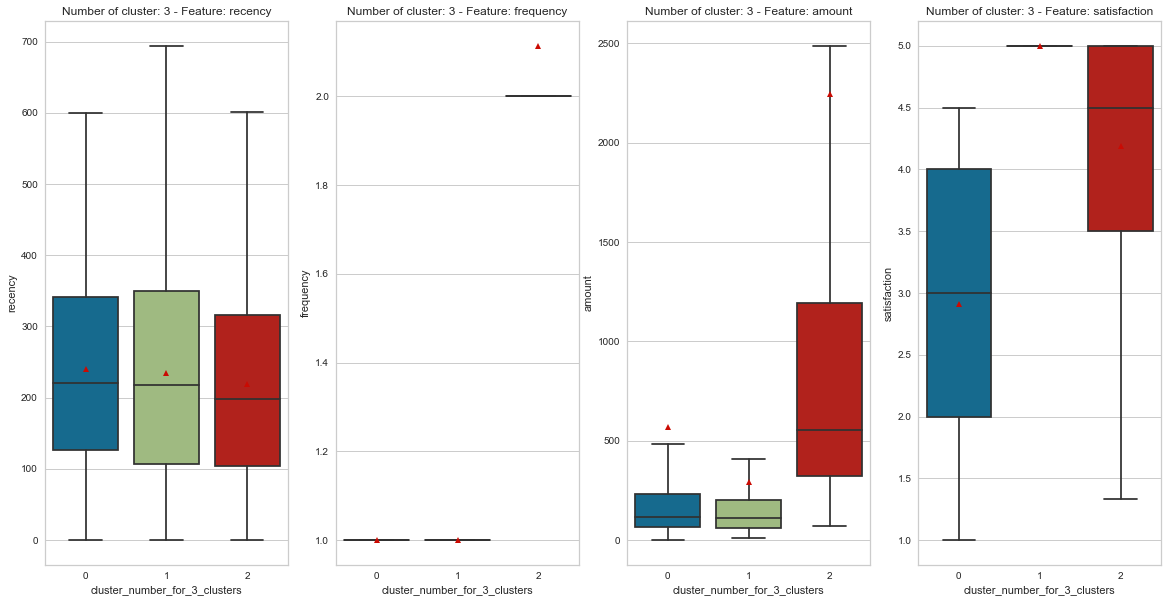

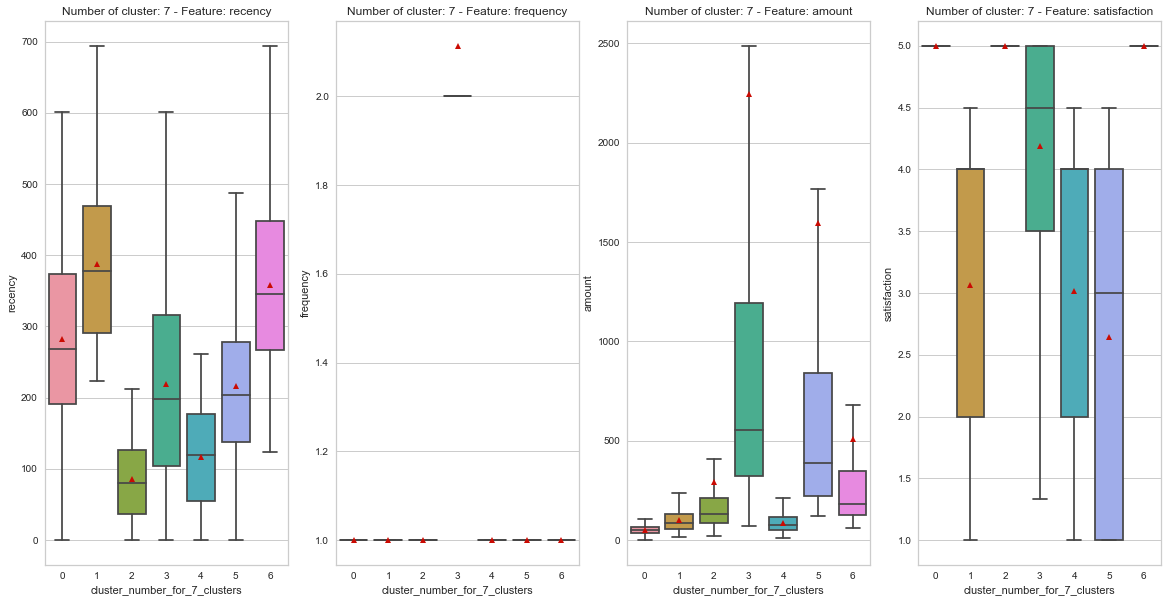

In [123]:
for i,j in enumerate(df4.iloc[:,4:]):
    clusterNumber = int(re.sub('cluster_number_for_',
                            '',
                            re.sub('\_clusters$',
                                    '',
                                    j)))
    plt.figure(figsize=(20,10))
    for k in range(4):
        plt.subplot(1,4,k+1)
        plt.title(f'Number of cluster: {clusterNumber} - Feature: {df4.columns[k]}')
        sns.boxplot(x=df4.iloc[:,i+4],
                    y=df4.iloc[:,k],
                    showfliers = False,
                    showmeans=True)

<u>Interprétation lorsque le jeu de donnée est divisé en</u> :
 - <u>3 clusters</u> :
  - **Cluster n°0** :
    - Regroupe les clients qui ont commandé plusieurs fois<br />
      et réalisés les achats les plus onéreux,<br />
      quelques soit leur récence ou satisfaction client.
  - **Cluster n°1** :
    - Regroupe les clients qui ont réalisé qu'un seul achat<br />
      mais qui ont une excellente satisfaction client (5 étoile sur 5 uniquement),<br />
      quel que soit le récence de l'achat,<br />
      mais pour un montant relativement modeste.
  - **Cluster n°2** :
    - Regroupe les clients qui n'ont pas une pleine satisfaction client,<br />
      qui ont commandé qu'une seule fois,<br />
      quelque soit la récence de l'achat<br />
      pour des montants relativement modeste même globalement<br />
      plus élevé que pour le cluster n°1.
 - <u>7 clusters</u> :
  - **Cluster n°0** :
    - Regroupe les clients qui ont effectué un seul achat<br />
      pour des montants très faibles<br />
      et qui ont été pleinement satisfait de leur achat<br />
      et exclu les clients les plus anciens.
  - **Cluster n°1** :
    - Regroupe les clients qui ont réalisés plusieurs achats<br />
      quelque soit leur récence, leur montant d'achat ou leur satisfaction.
  - **Cluster n°2** :
    - Regroupe les clients récent, qui ont réalisé un seul achat<br />
      pour un montant relativement modeste<br />
      mais qui ont été pleinement satisfait de leur achat.
  - **Cluster n°3** :
    - Regroupe les clients qui ont réalisés un seul achat<br />
      pour les montants les plus faibles<br />
      mais qui ont été pleinement satisfait de leur achat.
  - **Cluster n°4** :
    - Regroupe les clients anciens qui ont réalisé qu'un seul achat<br />
      pour des montants faibles à modérés<br />
      et qui ont été pleinement satisfait de leur achat.
  - **Cluster n°5** :
    - Regroupe les clients relativement récent<br />
      qui ont effectué qu'un seul achat sur le site<br />
      mais dont les montant sont élevés<br />
      sans inclure les clients les plus satisfaits.
  - **Cluster n°6** :
    - Regroupe les clients identiques au cluster n°0,<br />
      à l'exception près qu'ils sont parmi les plus récent.

## 20.5 Diagramme de Kiviat 

Le **diagramme de Kiviat** nous permet de visualiser rapidement<br />
et efficacement le profil client de chaque cluster.<br />
Le graphique affiche les valeurs moyennes, normalisés entre 0 et 1<br />
de chaque features, pour chaque cluster.<br />
Cela permet de déterminer d'un seul coup le profil type<br />
de chaque groupe de client que KMeans a identifié.

In [124]:
df4_kiviat = df4.copy()
df4_kiviat[['recency',
            'frequency',
            'amount',
            'satisfaction']] =\
    MinMaxScaler().fit_transform(PowerTransformer()
                                 .fit_transform(df4_kiviat[['recency',
                                                            'frequency',
                                                            'amount',
                                                            'satisfaction']]))

<u>Je ne conserve que le nombre de *clusters optimal*<br />
pour l'affichage des **Diagramme de Kiviat**</u> :

In [125]:
df4_kiviat = df4_kiviat[['recency',
                         'frequency',
                         'amount',
                         'satisfaction',
                         'cluster_number_for_7_clusters']]

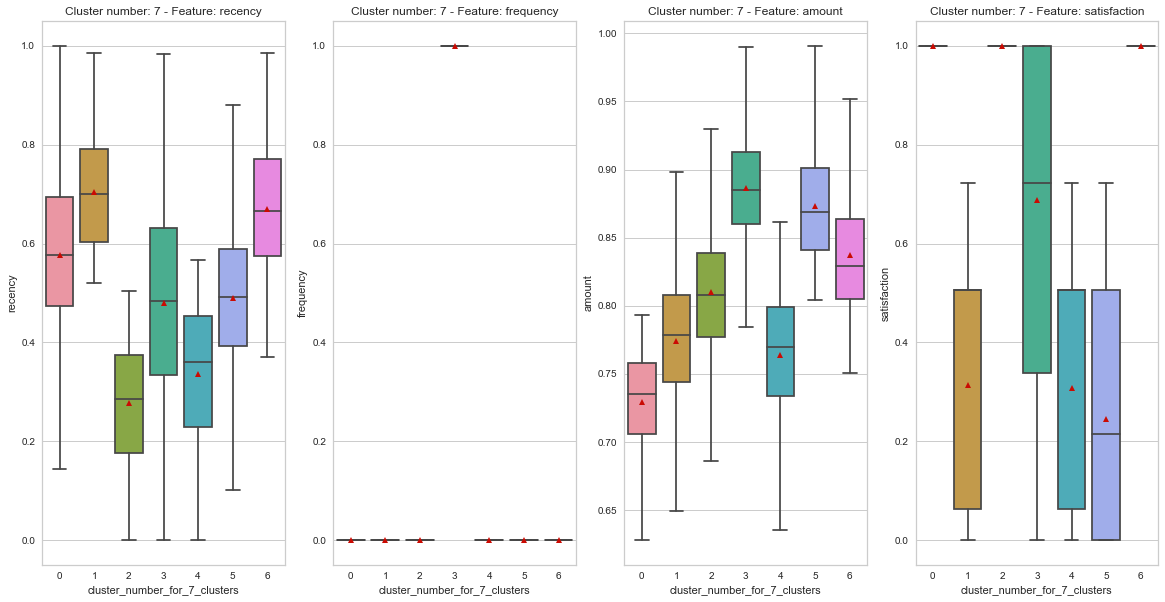

In [126]:
plt.figure(figsize=(20, 10))
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.title(f'Cluster number: 7 - Feature: {df4_kiviat.columns[k]}')
    sns.boxplot(x=df4_kiviat.iloc[:, -1],
                y=df4_kiviat.iloc[:, k],
                showfliers=False,
                showmeans=True)

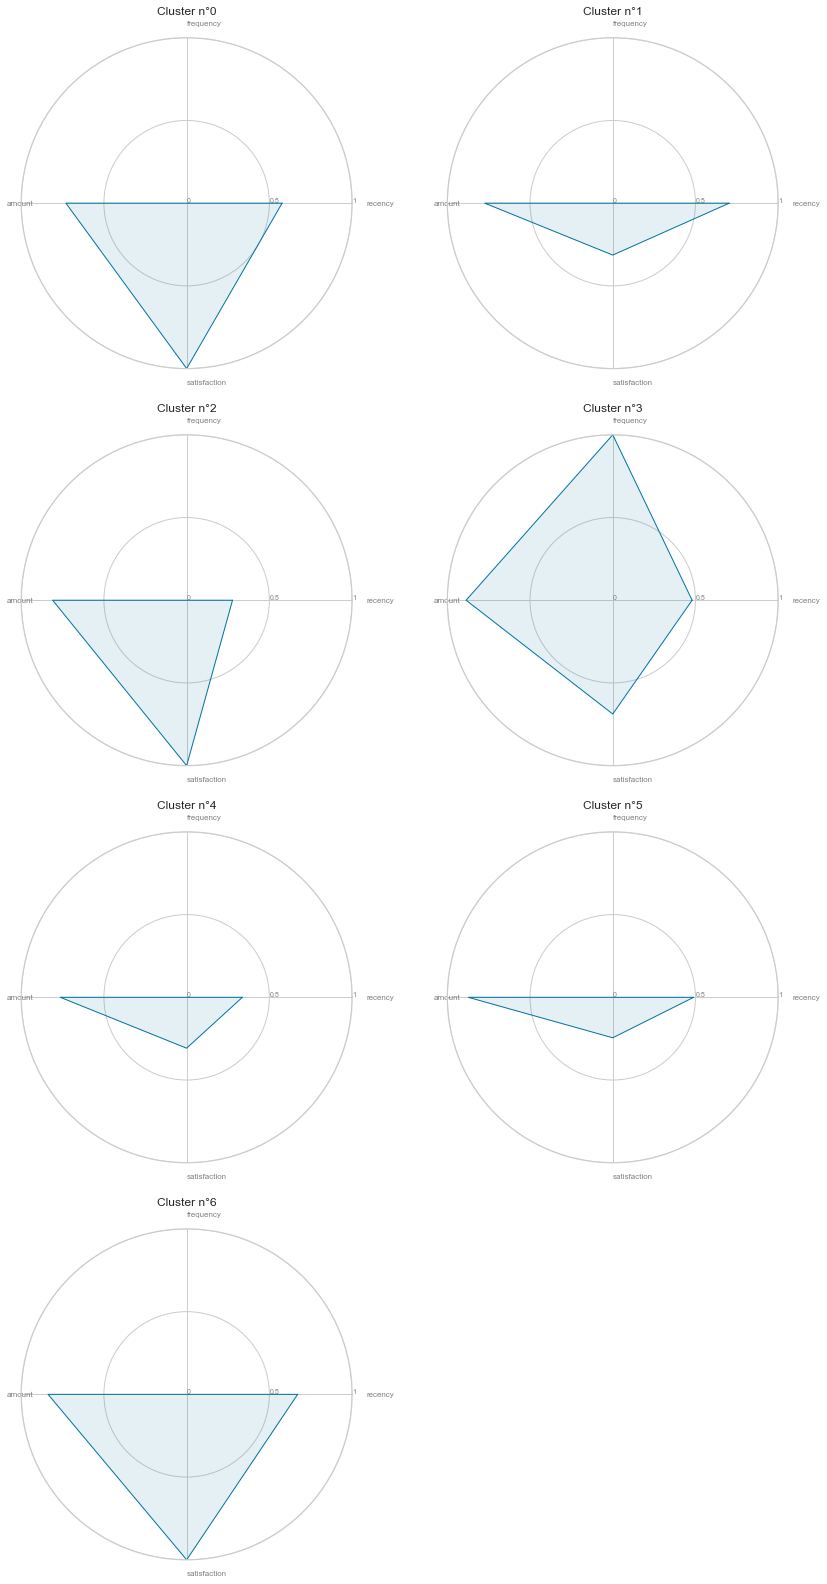

In [127]:
nbColumns = 2
nbRows = df4_kiviat.iloc[:, -1].nunique()//nbColumns +\
         (df4_kiviat.iloc[:, -1].nunique() % nbColumns > 0)
colClusters = df4_kiviat.columns[-1]
plt.figure(figsize=(7*nbColumns, 7*nbRows))
for i in sorted(df4_kiviat.iloc[:, -1].unique()):
    # number of variable
    categories = list(df4_kiviat)[:-1]
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = df4_kiviat[df4_kiviat[colClusters] == i]\
        .drop(colClusters, axis=1)\
        .mean().values.tolist()
    values += values[:1]
    # values

    # What will be the angle of each axis in the plot?
    # (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(nbRows, nbColumns, i+1, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1],
               categories,
               color='grey',
               size=8,
               ha='left')

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0, 0.5, 1], ["0", "0.5", "1"],
               color="grey",
               size=7)
    plt.ylim(0, 1)

    # Plot data
    ax.plot(angles,
            values,
            linewidth=1,
            linestyle='solid')

    # Fill area
    ax.fill(angles,
            values,
            'b',
            alpha=0.1)

    plt.title(f'Cluster n°{i}')

## 20.6 DBSCAN

DBSCAN est un algorithme de clustering qui s’appuie sur la densité <br />
estimée des clusters pour effectuer le partitionnement.

L'algorithme DBSCAN utilise 2 paramètres : 
 - La distance **epsilon**
 - Le nombre minimum de points **MinPts** devant se trouver <br />
   dans un rayon **epsilon** pour que ces points soient considérés<br />
   comme un cluster. 
   
Les paramètres d'entrées sont donc une estimation de la densité<br />
de points des clusters.<br />
L'idée de base de l'algorithme est ensuite, pour un point donné,<br />
de récupérer son **epsilon-voisinage** et de vérifier qu'il contient bien<br />
**MinPts** points ou plus.<br />
Ce point est alors considéré comme faisant partie d'un cluster.<br />
On parcourt ensuite l'**epsilon-voisinage** de proche en proche afin<br />
de trouver l'ensemble des points du cluster.

Contrairement à KMeans, ici nous ne choisissons pas<br />
à l'avance le nombre de Clusters.

<u>Suppression des colonnes contenant les clusters K-Means dans **df4std** et **df4**</u> :

In [128]:
df4std = df4std.iloc[:,:4]
df4 = df4.iloc[:,:4]

<u>Test de l'algorithme DBSCAN pour **EPS allant de 0.1 à 1.5** par pas de **0.1**</u> :

In [129]:
coeffSilhouette = []
numberOfCluster = []
for i in range(1,16):
    print('eps =',i/10)
    db4=DBSCAN(eps=i/10, min_samples=10,).fit(df4std)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db4.labels_)) - (1 if -1 in db4.labels_ else 0)
    
    coeffSilhouette.append(silhouette_score(df4std, db4.labels_))
    numberOfCluster.append(n_clusters_)

    # I assign the calculated labels in a new column of the DataFrame df4
    # for future analysis of the number of customers per cluster.
    df4['cluster_for_EPS_'+str(i/10)] =\
    pd.DataFrame(data=db4.labels_,
                 index=df4.index)

eps = 0.1
eps = 0.2
eps = 0.3
eps = 0.4
eps = 0.5
eps = 0.6
eps = 0.7
eps = 0.8
eps = 0.9
eps = 1.0
eps = 1.1
eps = 1.2
eps = 1.3
eps = 1.4
eps = 1.5


In [130]:
# Saving the coeffSilhouette and numberOfCluster Lists
pickle.dump(coeffSilhouette, open('dbscan_coeffSilhouette_4f', 'wb'))
pickle.dump(numberOfCluster, open('dbscan_numberOfCluster_4f', 'wb'))
# Restoration of the coeffSilhouette and numberOfCluster lists
# coeffSilhouette = pickle.load(open('dbscan_coeffSilhouette_4f', 'rb'))
# numberOfCluster = pickle.load(open('dbscan_numberOfCluster_4f', 'rb'))

<u>Pour chaque EPS testé, affichage du nombre de cluster et du coefficient de silhouette</u> :

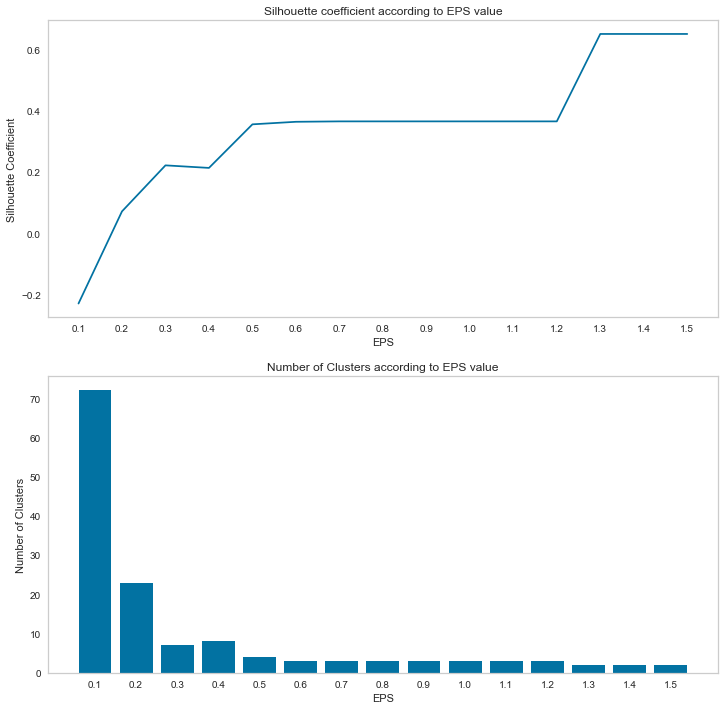

In [131]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(list(map(str, np.linspace(1,15,15,dtype='int')/10)), coeffSilhouette)
plt.grid()
plt.xlabel('EPS')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette coefficient according to EPS value')
plt.subplot(212)
plt.bar(list(map(str, np.linspace(1,15,15,dtype='int')/10)), numberOfCluster)
plt.grid()
plt.xlabel('EPS')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters according to EPS value')
plt.show()

<u>Affichage du nombre de clients / cluster en fonction de **EPS**</u> :

In [132]:
for i,j in enumerate(df4.columns[4:]):
    print('-----------------------------')
    print('Number of Clusters for EPS =',
          (i+1)/10,
          ':',
          df4[j].nunique())
    for index, value in df4[j].value_counts().sort_index().items():
        print(f'Cluster n°{index} -- Number of customers: {value}')
    print('-----------------------------')

-----------------------------
Number of Clusters for EPS = 0.1 : 73
Cluster n°-1 -- Number of customers: 4794
Cluster n°0 -- Number of customers: 17222
Cluster n°1 -- Number of customers: 52522
Cluster n°2 -- Number of customers: 17377
Cluster n°3 -- Number of customers: 18
Cluster n°4 -- Number of customers: 12
Cluster n°5 -- Number of customers: 14
Cluster n°6 -- Number of customers: 16
Cluster n°7 -- Number of customers: 18
Cluster n°8 -- Number of customers: 6
Cluster n°9 -- Number of customers: 15
Cluster n°10 -- Number of customers: 31
Cluster n°11 -- Number of customers: 16
Cluster n°12 -- Number of customers: 45
Cluster n°13 -- Number of customers: 39
Cluster n°14 -- Number of customers: 19
Cluster n°15 -- Number of customers: 13
Cluster n°16 -- Number of customers: 24
Cluster n°17 -- Number of customers: 18
Cluster n°18 -- Number of customers: 12
Cluster n°19 -- Number of customers: 14
Cluster n°20 -- Number of customers: 19
Cluster n°21 -- Number of customers: 14
Cluster n°22

L'utilisation de **DBSCAN** dans notre cas est <u>inexploitable</u><br />
pour une utilisation métier car les clusters ne sont pas équilibrés.

Nous avons par exemple des clusters contenants **une dizaine de clients**<br />
alors qu'un autre cluster en contient **52522**.

## 20.7 Agglomerative Clustering - Dendrogram

Le **dendrogramme** est une arborescence qui affiche les groupes formés<br />
par le regroupement des observations à chaque étape et leurs niveaux de similarité.<br />
Le niveau de **similarité** est mesuré le long de l'**axe vertical**<br />
et les **différentes observations** sont répertoriées le long de l'**axe horizontal**.

### 20.7.1 Test avec 10 000 données

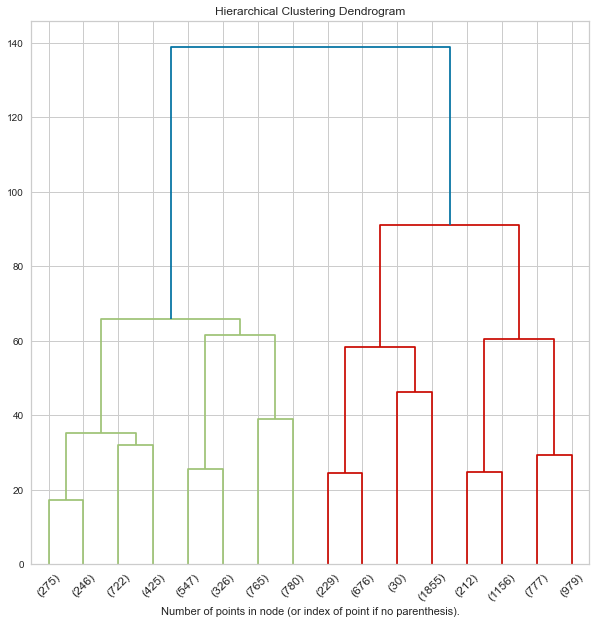

In [133]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# I select my data
X = df4std.iloc[:10000,:]

model = model.fit(X)
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.xticks(rotation=45)
plt.show()

<u>Plusieurs remarques sont à prendre en compte sur l'utilisation de cette méthode</u> :
- La méthode est lourde en calcul
 - Il est nécessaire dans notre cas de réaliser le test<br />
   sur une partie de notre jeu de donnée,<br />
   malheureusement le clustering risque d'être totalement différent<br />
   si nous le réalisons sur l'ensemble du jeu de donnée
- Les clusters ne sont pas équilibrés et s'étalent, dans notre exemple,<br />
  de 30 individus à 1855 individus, ce qui n'est pas exploitable<br />
  dans une problématique métier.

# 21. Test avec 5 features

<u>Features utilisées</u> :
- **R** --> **R**écence --> 'days_since_last_order'
- **F** --> **F**réquence --> 'total_of_orders'
- **M** --> **M**ontant --> 'total_amout_paid'
- **S** --> **S**atisfaction --> 'customer_satisfaction'
- **R** --> **R**etard de livraison --> 'late_delivery'


Création du DataFrame '**df5**' contenant les valeurs<br />
originales <u>non standardisées</u>, pour l'affichage<br />
des graphiques BoxPlot.

In [134]:
df5 = df_original.copy()[['days_since_last_order',
                          'total_of_orders',
                          'total_amout_paid',
                          'customer_satisfaction',
                          'late_delivery']]

Création du DataFrame '**df5std**'<br />
contenant les valeurs <u>standardisées</u> :

In [135]:
df5std = df_std[['days_since_last_order',
                 'total_of_orders',
                 'total_amout_paid',
                 'customer_satisfaction',
                 'late_delivery']]

<u>Je renomme les colonnes pour plus de lisibilité</u> :

In [136]:
df5.rename(columns={'days_since_last_order': 'recency',
                    'total_of_orders': 'frequency',
                    'total_amout_paid': 'amount',
                    'customer_satisfaction': 'satisfaction',
                    'late_delivery': 'delivery'},
           inplace=True)
df5std.rename(columns={'days_since_last_order': 'recency',
                       'total_of_orders': 'frequency',
                       'total_amout_paid': 'amount',
                       'customer_satisfaction': 'satisfaction',
                       'late_delivery': 'delivery'},
              inplace=True)

## 21.1 Coefficient de silhouette

Le **coefficient de silhouette** est <u>une mesure de<br />
qualité d'une partition d'un ensemble de données</u>.

Pour chaque point, son coefficient de silhouette<br />
est la différence entre la distance moyenne<br />
avec les points du même groupe que lui (cohésion)<br /> 
et la distance moyenne avec les points des autres<br />
groupes voisins (séparation).

Si cette différence est **négative**,<br />
le point est en moyenne plus proche du groupe voisin<br />
que du sien et il est donc <u>mal classé</u>.

A l'inverse, si cette différence est **positive**,<br />
le point est en moyenne plus proche de son groupe<br />
que du groupe voisin et il est donc <u>bien classé</u>.

Le coefficient de silhouette proprement dit est<br />
la moyenne du coefficient de silhouette pour tous les points.

J'utilise l'algorithme KMeans pour calculer le coefficient <br />
de silhouette, pour différents nombres de clusters allant de **3** à **20**.<br />
Nous analyserons ensuite la valeurs des différents coefficients<br />
de silhouette pour déterminer, à priori, le nombre optimal de clusters.<br />
Nous utiliserons également la méthode du coude via la fonction **KElbowVisualizer**.

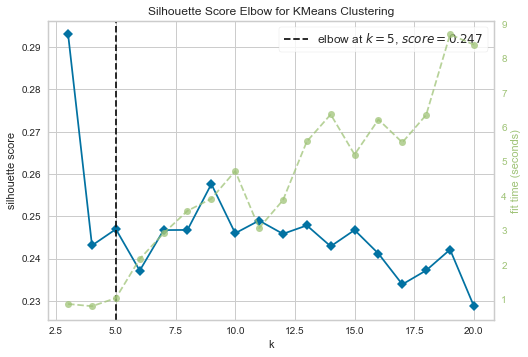

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [137]:
model = KMeans()
visualizer = KElbowVisualizer(model, 
                              k=(3,21),
                              metric='silhouette', 
                              timings=True)

visualizer.fit(df5std)
visualizer.poof()

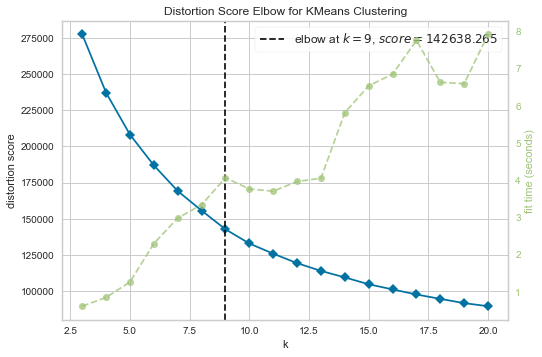

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [138]:
model = KMeans()
visualizer = KElbowVisualizer(model,
                              k=(3, 21))

visualizer.fit(df5std)
visualizer.poof()

Les valeurs du coefficient de silhouette ne varient pas<br />
significativement quel que soit la valeur de k.<br />
Cependant, on peut noter que les valeurs de k <br />
les plus optimisés sont **3** et **9**.

<u>Affichons maintenant les différents clusters en fonction de leur population</u> :

Le visualiseur de silhouette affiche le coefficient de silhouette pour chaque cluster,<br />
en évaluant visuellement leur densité et leur séparation par rapport aux autres clusters. 

Le score est calculé en faisant la moyenne du coefficient de silhouette<br />
pour chaque échantillon par cluster, calculé comme la différence<br />
entre la distance moyenne intra-cluster et la distance moyenne<br />
au plus proche cluster pour chaque échantillon,<br />
normalisée par la valeur maximale.<br />
Cela donne un score entre **-1** et **+1**, où les scores proches de +1 indiquent<br />
une séparation élevée et les scores proches de **-1** indiquent<br />
que les échantillons peuvent avoir été affectés au mauvais cluster.

Dans les graphiques de **SilhouetteVisualizer**, les clusters ayant des scores<br />
plus élevés ont des silhouettes plus larges, mais les grappes qui sont moins<br />
cohésives n'atteignent pas le score moyen de toutes les cluster,<br />
qui est représenté par une ligne verticale pointillée en rouge.

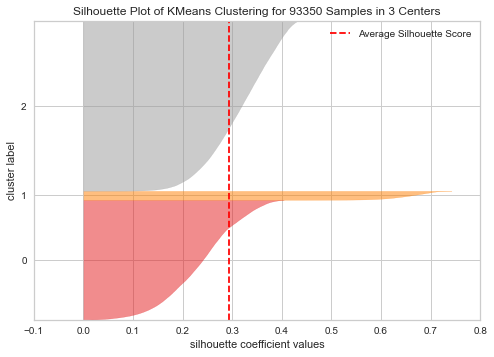

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93350 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [139]:
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df5std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Les clusters ne sont pas très homogènes.
Ils se distinguent tous par une population<br />
et un score de coefficient de silhouette moyen nettement différents.

Un des clusters se démarque particulièrement des deux autres par une population<br />
beaucoup plus faible et un coefficient de silhouette nettement plus élevé.

Enfin, aucun des clusters n'a d'échantillon avec un coefficient de silhouette inférieur à 0.

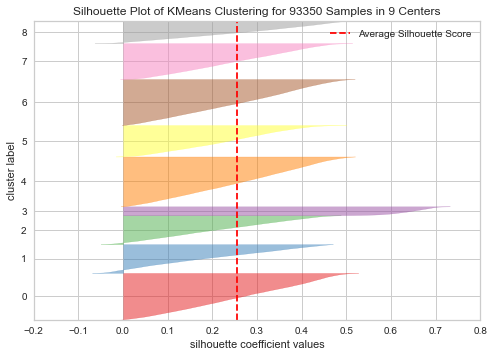

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93350 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [140]:
model = KMeans(9)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df5std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Ici aussi les clusters ne semblent pas très homogènes entre-eux.

De plus certains clusters ont des échantillons de leur population<br />
avec des coefficients de silhouette inférieurs à 0 et atteignant parfois -0.8.

On retrouve cependant notre cluster ayant une faible population<br />
mais un coefficient de silhouette élevé.

A ce stade, avec 5 features, il me semble plus pertinent<br />
de partitionner nos clients en 3 clusters.

## 21.2 K-Means

Utilisation de K-Means pour calculer 3 et 9 clusters,<br />
les valeurs optimales en nombre de clusters d'après le **coefficient de silhouette**.

In [141]:
for i in [3,9]:
    print('n_clusters =',i)
    df5['cluster_number_for_'+str(i)+'_clusters'] =\
    pd.DataFrame(data=KMeans(n_clusters=i).fit(df5std).labels_,
                 index=df5.index)

n_clusters = 3
n_clusters = 9


In [142]:
df5.head(3).T

,0,1,2
recency,470.00000,228.00000,101.00000
frequency,1.00000,1.00000,1.00000
amount,146.87000,335.48000,157.73000
satisfaction,4.00000,5.00000,5.00000
delivery,11.00000,8.00000,-1.00000
cluster_number_for_3_clusters,2.00000,1.00000,1.00000
cluster_number_for_9_clusters,7.00000,2.00000,6.00000


## 21.3 PCA

<u>J'applique une Analyse en Composante Principale à mon jeu de donnée <br />
en le ramenant en 2 dimensions afin de pouvoir visualiser graphiquement<br />
les différents clusters</u> :

In [143]:
pca = PCA(n_components=2)
pca.fit(df5std)
print('Variance explained by the two principals components:',
      pca.explained_variance_ratio_.cumsum()[-1])
X_pca = pca.transform(df5std)

Variance explained by the two principals components: 0.4912358500623355


<u>Affichage des clusters en fonction du nombre total de clusters</u> : 

-----------------------------
Number of clusters: 3
Cluster n°0 -- number of customers: 2801
Cluster n°1 -- number of customers: 53095
Cluster n°2 -- number of customers: 37454
-----------------------------
-----------------------------
Number of clusters: 9
Cluster n°0 -- number of customers: 8212
Cluster n°1 -- number of customers: 9684
Cluster n°2 -- number of customers: 15802
Cluster n°3 -- number of customers: 2801
Cluster n°4 -- number of customers: 9051
Cluster n°5 -- number of customers: 14485
Cluster n°6 -- number of customers: 15157
Cluster n°7 -- number of customers: 11282
Cluster n°8 -- number of customers: 6876
-----------------------------


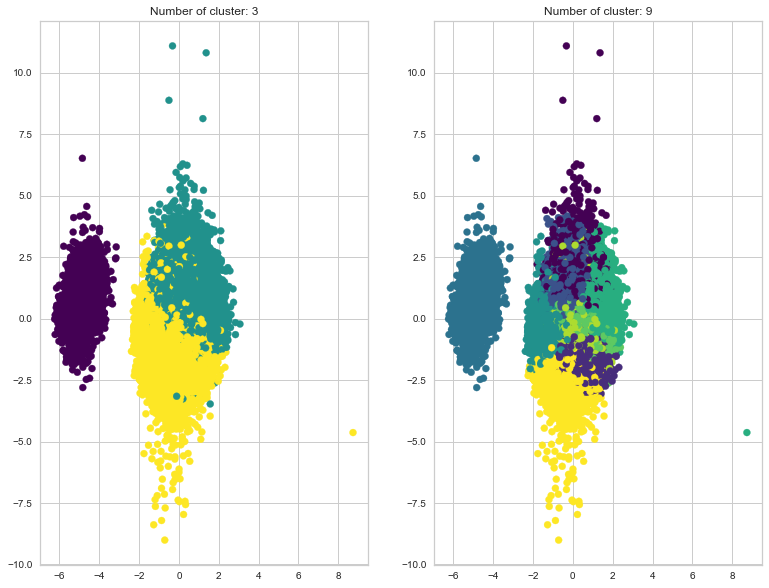

In [144]:
plt.figure(figsize=(20, 10))
nbColumns = 3
nbRows = len(df5.columns[5:])//nbColumns +\
        (len(df5.columns[5:])%nbColumns > 0)
for i,j in enumerate(df5.columns[5:]):
    # Extract the number of clusters
    clusterNumber = int(re.sub('cluster_number_for_',
                            '',
                            re.sub('\_clusters$',
                                    '',
                                    j)))
    # Plot Clusters
    plt.subplot(nbRows,nbColumns,i+1)
    plt.scatter(X_pca[:, 0],
                X_pca[:, 1],
                c=df5[j],
                cmap="viridis")
    plt.title(f'Number of cluster: {clusterNumber}')
    print('-----------------------------')
    print('Number of clusters:',clusterNumber)
    for k,l in enumerate(df5[j].value_counts().sort_index()):
        print(f'Cluster n°{k} -- number of customers: {l}')
    print('-----------------------------')

<u>Affichage du nombre de Clients/Cluster en fonction du nombre de clusters total</u> :

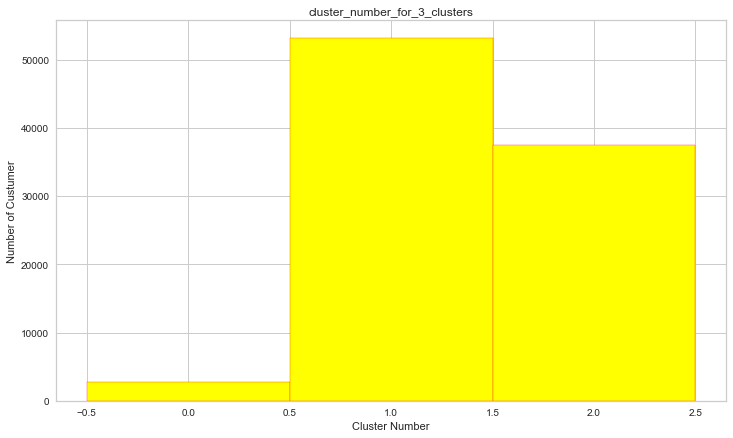

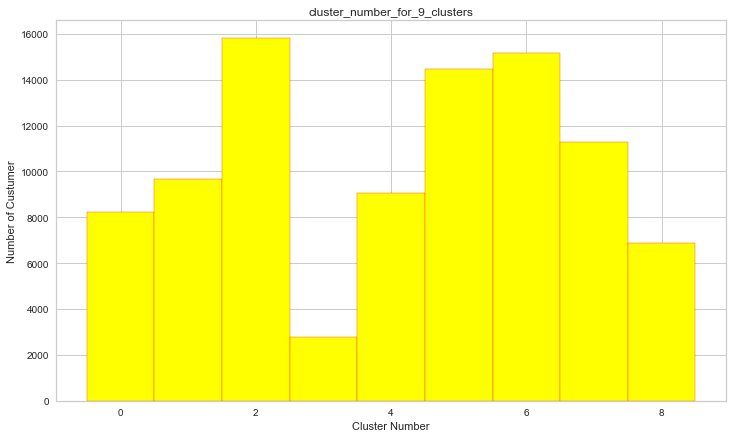

In [145]:
for i,j in enumerate(df5.iloc[:,5:]):
    clusterNumber = int(re.sub('cluster_number_for_',
                            '',
                            re.sub('\_clusters$',
                                    '',
                                    j)))
    plt.figure(figsize=(12,7))
    plt.hist(df5[j],
             range=(0, clusterNumber),
             bins=clusterNumber,
             color='yellow', 
             edgecolor = 'red',
             align='left')
    plt.title(j)
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Custumer')

## 21.4 Graphique BoxPlot

J'affiche pour chaque feature,<br />
les différents clusters sous forme de boxplot<br />
en fonction du nombre de clusters total.

Cette visualisation doit nous permettre de comprendre<br />
et d'interpréter les profils des différents clients.

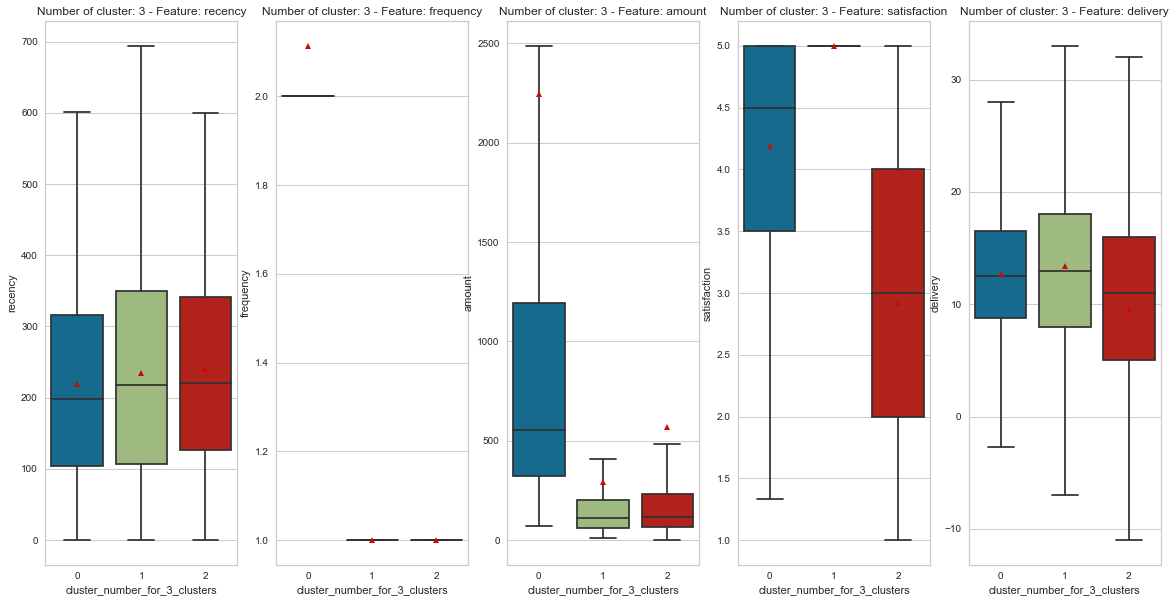

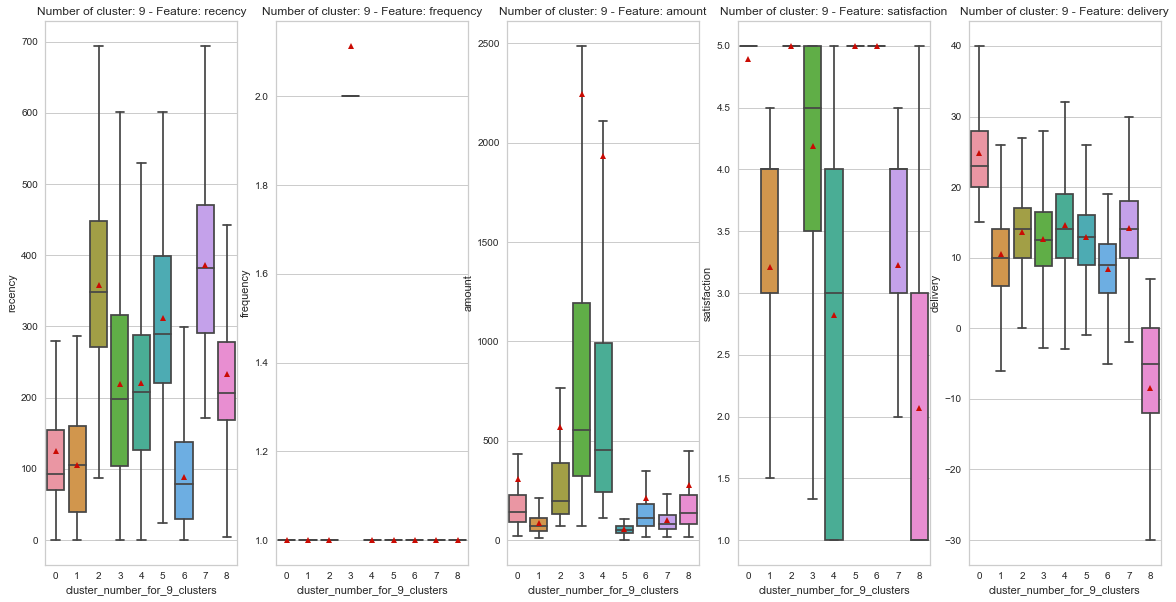

In [146]:
for i,j in enumerate(df5.iloc[:,5:]):
    clusterNumber = int(re.sub('cluster_number_for_',
                            '',
                            re.sub('\_clusters$',
                                    '',
                                    j)))
    plt.figure(figsize=(20,10))
    for k in range(5):
        plt.subplot(1,5,k+1)
        plt.title(f'Number of cluster: {clusterNumber} - Feature: {df5.columns[k]}')
        sns.boxplot(x=df5.iloc[:,i+5],
                    y=df5.iloc[:,k],
                    showfliers = False,
                    showmeans=True)

<u>Interpretation lorsque le jeu de donnée est divisé en</u> :
 - <u>3 clusters</u> :
  - **Cluster n°0** :
    - Regroupe les clients les plus satisfaits,<br />
      qui ont effectué qu'une seule commande<br />
      pour des montants relativement faibles.
  - **Cluster n°1** :
    - Regroupe les clients qui ont commandés plusieurs fois sur le site<br />
      indépendement des autres features.
  - **Cluster n°2** : 
    - Regroupe les clients semblables au cluster n°0<br />
      sans se concentrer sur les clients les plus satisfaits,<br />
      il ne fait pas de distinction sur cette feature.<br />
      Les montants commandés sont également un peu plus élevés<br />
      que pour le cluster n°0.
 - <u>9 clusters</u> :
  - **Cluster n°0** :
    - Regroupe les client récents, qui ont réalisé qu'un seul achat,<br />
      pour un faible montant et qui ont été livré un peu en avance<br />
      et qui sont pleinement satisfaits de leur achat.
  - **Cluster n°1** :
    - Regroupe les clients semblables au cluster n°0 à la différence<br />
      que ce cluster exclu les clients pleinement satisfaits de leur achat.<br />
      Egalement les montants commandés sont globalement plus faible.
  - **Cluster n°2** :
    - Regroupe les clients semblables au cluster n°0 mais se différencie<br />
      en regroupant les clients livrés les plus en avance par rapport<br />
      à la date de livraison estimés.
  - **Cluster n°3** :
    - Regroupe les clients qui ont commandé une seule fois<br />
      pour des montants faibles à moyens, qui ont été livré soit<br />
      en temps et en heure soit en avance et qui sont pleinement satisfait<br />
      de leur achat. Ce cluster exclu toute fois les clients les plus récents.
  - **Cluster n°4** :
    - Regroupe les clients qui ont commandé plusieurs fois<br />
      sans qu'il n'y ait de sélection particulière sur les autres features.<br />
      On notera cependant l'exclusion des clients les plus anciens,<br />
      et des clients ayant subi des retards de livraison.
  - **Cluster n°5** :
    - Regroupe les clients qui ont été livrés en retard,<br />
      sans distinction de leur satisfaction client,<br />
      qui ont effectué qu'un seul achat pour un montant faible à bas.
  - **Cluster n°6** :
    - Regroupe les clients ayant effectués les plus petits achats<br />
      et qui ont effectués qu'une seul commande mais<br />
      qui sont pleinement satisfait de leur achat. 
  - **Cluster n°7**
    - Regroupe les clients ayant effectués un seul achat<br />
      d'un montant relativement bas et<br />
      qui ne sont pas pleinement satisfait de leur achat.
  - **Cluster n°8**
    - Regroupe les clients qui ont effectué une seule commande<br />
      pour un montant globalement très élevé et<br />
      qui ne sont pas pleinement satisfait de leur achat.

## 21.5 Diagramme de Kiviat 

Le **diagramme de Kiviat** nous permet de visualiser rapidement<br />
et efficacement le profil client de chaque cluster.<br />
Le graphique affiche les valeurs moyennes, normalisés entre 0 et 1<br />
de chaque features, pour chaque cluster.<br />
Cela permet de déterminer d'un seul coup le profil type<br />
de chaque groupe de client que KMeans a identifié.

In [147]:
df5_kiviat = df5.copy()
df5_kiviat[['recency', 
            'frequency', 
            'amount',
            'satisfaction',
            'delivery']] = MinMaxScaler()\
                           .fit_transform(PowerTransformer()\
                           .fit_transform(df5_kiviat[['recency',
                                                      'frequency',
                                                      'amount',
                                                      'satisfaction',
                                                      'delivery']]))

<u>Je ne conserve que le nombre de *clusters optimal*<br />
pour l'affichage des **Diagrammes de Kiviat**</u> :

In [148]:
df5_kiviat = df5_kiviat[['recency',
                         'frequency',
                         'amount',
                         'satisfaction',
                         'delivery',
                         'cluster_number_for_3_clusters']]

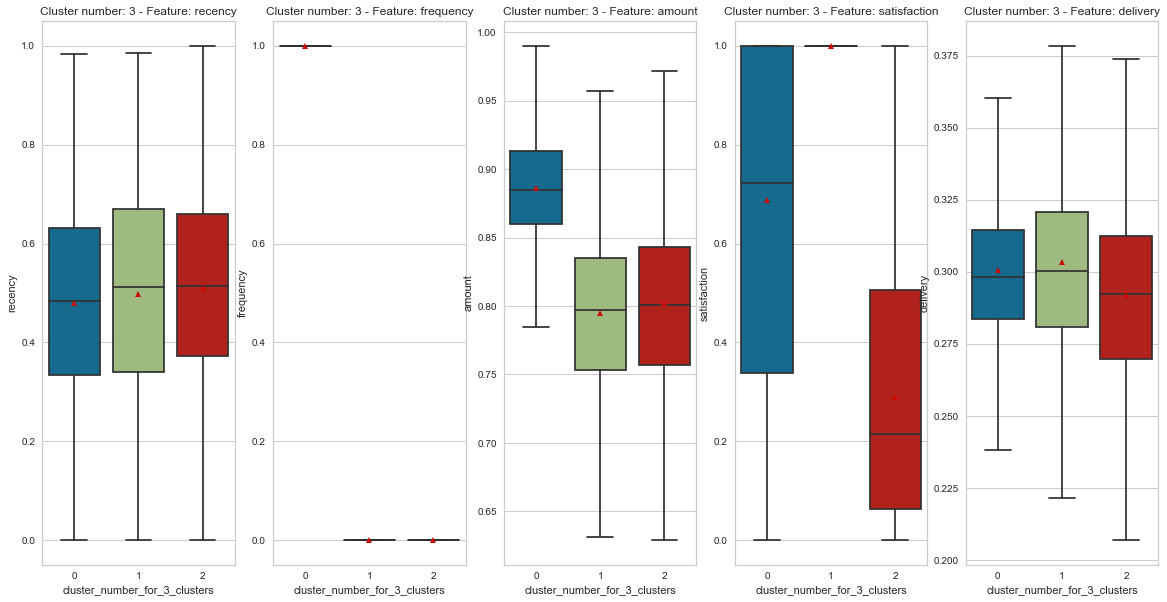

In [149]:
plt.figure(figsize=(20,10))
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.title(f'Cluster number: 3 - Feature: {df5_kiviat.columns[k]}')
    sns.boxplot(x=df5_kiviat.iloc[:,-1],
                y=df5_kiviat.iloc[:,k],
                showfliers = False,
                showmeans=True)

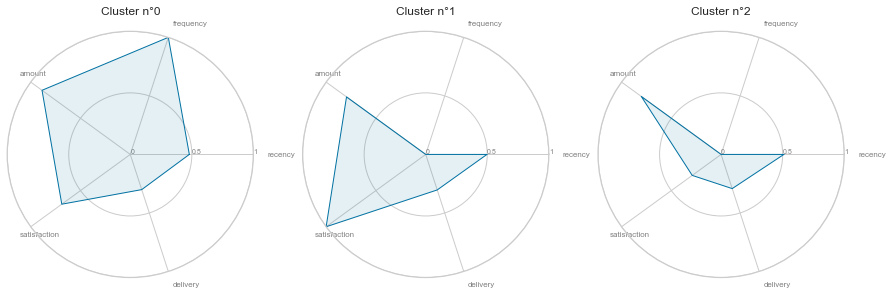

In [150]:
nbColumns = 3
nbRows = df5_kiviat.iloc[:,-1].nunique()//nbColumns +\
         (df5_kiviat.iloc[:,-1].nunique()%nbColumns > 0)
colClusters = df5_kiviat.columns[-1]
plt.figure(figsize=(15,5*nbRows))
for i in sorted(df5_kiviat.iloc[:,-1].unique()):
    # number of variable
    categories=list(df5_kiviat)[:-1]
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values=df5_kiviat[df5_kiviat[colClusters] == i]\
           .drop(colClusters, axis=1)\
           .mean().values.tolist()
    values += values[:1]
   
    # What will be the angle of each axis in the plot?
    # (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
   
    # Initialise the spider plot
    ax = plt.subplot(nbRows,nbColumns,i+1, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1],
               categories,
               color='grey',
               size=8,
               ha='left')

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,0.5,1], ["0","0.5","1"],
               color="grey",
               size=7)
    plt.ylim(0,1)

    # Plot data
    ax.plot(angles,
            values,
            linewidth=1,
            linestyle='solid')
    
    # Fill area
    ax.fill(angles,
            values,
            'b',
            alpha=0.1)
    
    plt.title(f'Cluster n°{i}')

## 21.6 DBSCAN

DBSCAN est un algorithme de clustering qui s’appuie sur la densité <br />
estimée des clusters pour effectuer le partitionnement.

L'algorithme DBSCAN utilise 2 paramètres : 
 - La distance **epsilon**
 - Le nombre minimum de points **MinPts** devant se trouver <br />
   dans un rayon **epsilon** pour que ces points soient considérés<br />
   comme un cluster. 
   
Les paramètres d'entrées sont donc une estimation de la densité<br />
de points des clusters.<br />
L'idée de base de l'algorithme est ensuite, pour un point donné,<br />
de récupérer son **epsilon-voisinage** et de vérifier qu'il contient bien<br />
**MinPts** points ou plus.<br />
Ce point est alors considéré comme faisant partie d'un cluster.<br />
On parcourt ensuite l'**epsilon-voisinage** de proche en proche afin<br />
de trouver l'ensemble des points du cluster.

Contrairement à KMeans, ici nous ne choisissons pas<br />
à l'avance le nombre de Cluster.

<u>Suppression des colonnes contenant les clusters K-Means dans **df5std** et **df5**</u> :

In [151]:
df5std = df5std.iloc[:,:5]
df5 = df5.iloc[:,:5]

<u>Test de l'algorithme DBSCAN pour **EPS allant de 0.1 à 1.5** par pas de **0.1**</u> :

In [152]:
coeffSilhouette = []
numberOfCluster = []
for i in range(1,16):
    print('eps =',i/10)
    db5=DBSCAN(eps=i/10, min_samples=10,).fit(df5std)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db5.labels_)) - (1 if -1 in db5.labels_ else 0)
    
    coeffSilhouette.append(silhouette_score(df5std, db5.labels_))
    numberOfCluster.append(n_clusters_)

    # I assign the calculated labels in a new column of the DataFrame df5
    # for future analysis of the number of customers per cluster.
    df5['cluster_for_EPS_'+str(i/10)] =\
    pd.DataFrame(data=db5.labels_,
                 index=df5.index)

eps = 0.1
eps = 0.2
eps = 0.3
eps = 0.4
eps = 0.5
eps = 0.6
eps = 0.7
eps = 0.8
eps = 0.9
eps = 1.0
eps = 1.1
eps = 1.2
eps = 1.3
eps = 1.4
eps = 1.5


In [153]:
# Sauvegarde des List coeffSilhouette et numberOfCluster
pickle.dump(coeffSilhouette, open('dbscan_coeffSilhouette_5f', 'wb'))
pickle.dump(numberOfCluster, open('dbscan_numberOfCluster_5f', 'wb'))
# Restauration des List coeffSilhouette et numberOfCluster
# coeffSilhouette = pickle.load(open('dbscan_coeffSilhouette_5f', 'rb'))
# numberOfCluster = pickle.load(open('dbscan_numberOfCluster_5f', 'rb'))

<u>Pour chaque **EPS** testé, affichage du nombre de clusters et du coefficient de silhouette </u> :

Text(0.5, 1.0, 'Number of Clusters according to EPS value')

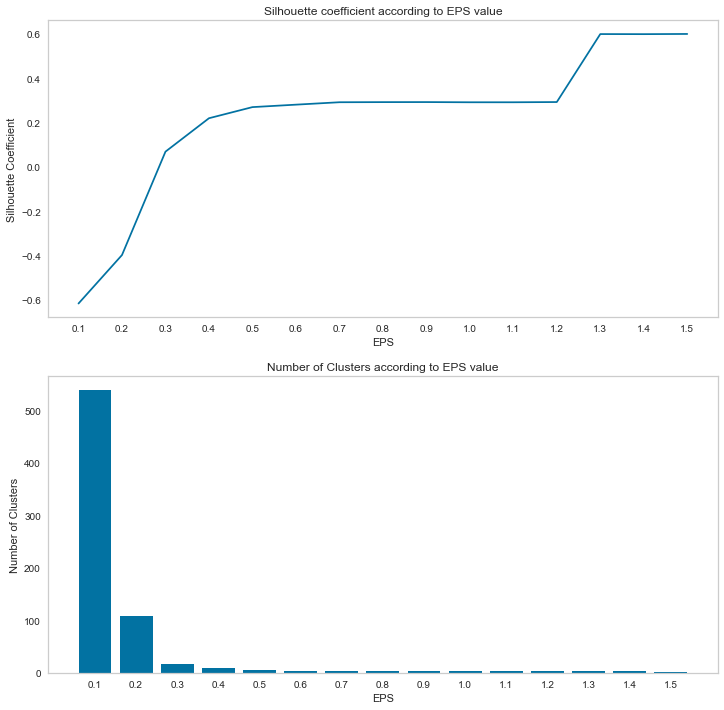

In [154]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(list(map(str, np.linspace(1,15,15,dtype='int')/10)), coeffSilhouette)
plt.grid()
plt.xlabel('EPS')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette coefficient according to EPS value')
plt.subplot(212)
plt.bar(list(map(str, np.linspace(1,15,15,dtype='int')/10)), numberOfCluster)
plt.grid()
plt.xlabel('EPS')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters according to EPS value')

<u>Affichage du nombre de clients / cluster en fonction de **EPS**</u> :

In [155]:
for i,j in enumerate(df5.columns[5:]):
    print('-----------------------------')
    print('Number of Clusters for EPS =',
          (i+1)/10,
          ':',
          df5[j].nunique())
    for index, value in df5[j].value_counts().sort_index().items():
        print(f'Cluster n°{index} -- Number of customers: {value}')
    print('-----------------------------')

-----------------------------
Number of Clusters for EPS = 0.1 : 539
Cluster n°-1 -- Number of customers: 66278
Cluster n°0 -- Number of customers: 2079
Cluster n°1 -- Number of customers: 1025
Cluster n°2 -- Number of customers: 2725
Cluster n°3 -- Number of customers: 544
Cluster n°4 -- Number of customers: 481
Cluster n°5 -- Number of customers: 972
Cluster n°6 -- Number of customers: 122
Cluster n°7 -- Number of customers: 14
Cluster n°8 -- Number of customers: 518
Cluster n°9 -- Number of customers: 1008
Cluster n°10 -- Number of customers: 158
Cluster n°11 -- Number of customers: 1155
Cluster n°12 -- Number of customers: 88
Cluster n°13 -- Number of customers: 27
Cluster n°14 -- Number of customers: 316
Cluster n°15 -- Number of customers: 1733
Cluster n°16 -- Number of customers: 198
Cluster n°17 -- Number of customers: 81
Cluster n°18 -- Number of customers: 437
Cluster n°19 -- Number of customers: 63
Cluster n°20 -- Number of customers: 488
Cluster n°21 -- Number of customers:

L'utilisation de **DBSCAN** dans notre cas est <u>inexploitable</u><br />
pour une utilisation métier car les clusters ne sont pas équilibrés.

Nous avons par exemple des clusters contenants **une dizaine de clients**<br />
alors qu'un autre cluster en contient **92290**.

## 21.7 Agglomerative Clustering - Dendrogram

Le **dendrogramme** est une arborescence qui affiche les groupes formés<br />
par le regroupement des observations à chaque étape et leurs niveaux de similarité.<br />
Le niveau de **similarité** est mesuré le long de l'**axe vertical**<br />
et les **différentes observations** sont répertoriées le long de l'**axe horizontal**.

### 21.7.1 Test avec 10 000 données

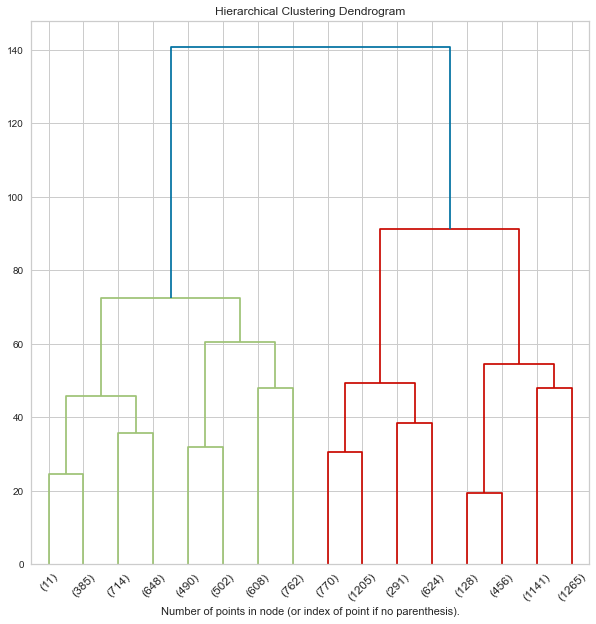

In [156]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# I select my data
X = df5std.iloc[:10000,:]

model = model.fit(X)
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.xticks(rotation=45)
plt.show()

<u>Plusieurs remarques sont à prendre en compte sur l'utilisation de cette méthode</u> :
- La méthode est lourde en calcul
 - Il est nécessaire dans notre cas de réaliser le test<br />
   sur une partie de notre jeu de donnée,<br />
   malheureusement le clustering risque d'être totalement différent<br />
   si nous le réalisons sur l'ensemble du jeu de donnée
- Les clusters ne sont pas équilibrés et s'étalent, dans notre exemple,<br />
  de 30 individus à 1389 individus, ce qui n'est pas exploitable<br />
  dans une problématique métier.

# 22. Contrat de Maintenance

Nous allons dans cette partie étudier<br />
la stabilité des clusters au cours du temps.<br />
A la suite à cette étude, nous réaliserons<br />
une proposition de contrat de maintenance.

Pour étudier la stabilité des clusters<br />
au cours du temps, nous allons calculer<br />
l'écart entre un *predict* du modèle initial<br />
et le *fit* d'un nouveau modèle grâce à<br />
la fonction *Ajusted_Rand_Score* de la façon suivante:<br />
*adjusted_rand_score(labels_true, labels_pred)*

La fonction *Ajusted_Rand_Score*<br />
calcule une mesure de similarité<br />
entre deux clusters en considérant<br />
toutes les paires d'échantillons<br />
et en comptant les paires qui sont<br />
assignées dans le même cluster<br />
ou dans des clusters différents<br />
dans les clusters prédits et réels.

<u>Je nomme</u> :
 - **labels_true** :
  - Les labels obtenus à partir de l'attribue **labels_**<br />
    d'un KMeans entrainé avec les données à l'instant **t+n**.
 - **labels_pred** :
  - Les labels obtenus à partir d'un *predict* des données<br />
    actuelles d'un KMeans entrainé avec les donnée à l'instant **t**.

Nous appellerons les différentes périodes<br />
de temps: t, t+1, t+2,..., t+n<br />
où 'n' représente le nombre de mois<br />
entre la période initiale et la période finale.

Nous commencerons notre clusterisation<br />
avec l'état de la base de données ayant<br />
1an d'existence (t=12 mois)<br />
Nous recommencerons les clusterisations<br />
en ajoutant 1 mois de commande, et ainsi de suite.<br />
A chaque itération, nous comparerons<br />
l'état des clusters.

Lorsque l'*Ajusted_Rand_Score* obtenu est inférieur à 0.8,<br />
nous considérerons que les clusters ne sont plus stables<br />
et il sera donc nécessaire de réaliser un nouveau<br />
clustering sur les données les plus récentes disponibles.

Nous allons donc calculer la période nécessaire<br />
durant laquelle l'*Ajusted_Rand_Score* passera<br />
systématiquement sous 0.8 et nous établirons<br />
notre proposition de contrat à partir de cette information.

## 22.1 Modèle et nombre de features retenus

<u>A la suite aux tests précédents, je décide 
d'utiliser</u> :
 - 4 features dans mon jeu de données :
    - R --> **R**écence --> 'days_since_last_order'
    - F --> **F**réquence --> 'total_of_orders'
    - M --> **M**ontant --> 'total_amout_paid'
    - S --> **S**atisfaction --> 'customer_satisfaction'
 - L'algorithme KMeans
 - 7 clusters

## 22.2 Description des différentes étapes

Nous allons recréer le processus nous permettant<br />
de partir des données importées en début de projet<br />
pour arriver au <u>calcul des labels d'un KMeans à<br />
7 Cluster</u> sur un jeu de donnée contenant les<br />
commandes clients d'une <u>période de temps choisie</u>.

Chaque étape du processus est<br />
matérialisée par une fonction à<br /> 
l'exception de la 1ère étape.

 - <u>1ère étape</u> : Création du DataFrame *data*
  - *data* contiendra les features minimales, nécessaires<br />
    aux futurs calculs des features **Récence**,<br />
    **Fréquence**, **Montant** et **Satisfaction** 
 - <u>2ème étape</u> : Filtrer *data* sur une période de temps définie
 - <u>3ème étape</u> : Calculer les features **RFMS**
  - R --> **R**écence --> 'days_since_last_order'
  - F --> **F**réquence --> 'total_of_orders'
  - M --> **M**ontant --> 'total_amout_paid'
  - S --> **S**atisfaction --> 'customer_satisfaction'
 - <u>4ème étape</u> : Standardisation des données
  - Powertransform
  - MinMaxScaler
 - <u>5ème étape</u> : Calcul du KMeans
  - Indication du nombre de clusters choisi (ici 7)
 - <u>6ème étape</u> : Calcul de l'Ajusted_Rand_Score
  - Réaliser les étape 1 à 5 pour la période **t**
  - Réaliser les étape 1 à 5 pour la période **t+n**

## 22.3 Création du DataFrame data

<u>Nous avons besoin des features suivantes</u> :
 - 'customer_unique_id' et 'customer_id' contenus dans : **df_customer**
 - 'order_approved_at' contenu dans : **df_orders**
 - 'order_purchase_timestamp' contenu dans : **df_orders**
 - 'payment_value' contenu dans : **df_payments**
 - 'review_score' contenu dans : **df_reviews**

In [157]:
data = df_customer[['customer_id',
                    'customer_unique_id']]\
       .merge(df_orders[['customer_id',
                         'order_id',
                         'order_approved_at',
                         'order_purchase_timestamp']],
              on='customer_id',
              how='left')\
       .merge(df_reviews[['order_id',
                          'review_score']],
              on='order_id',
              how='left')\
       .merge(df_payments[['order_id',
                           'payment_value']],
              on='order_id',
              how='left')

<u>Je convertis la colonne '**order_purchase_timestamp**'<br />
dans le bon format</u> :

In [158]:
data['order_purchase_timestamp'] = \
    pd.to_datetime(data['order_purchase_timestamp'])

## 22.4 Création des fonctions nécessaires<br />au calcul de l'*Ajusted_Rand_Score*

In [159]:
def dataByPeriode(myData, nbMonth):
    '''
    Takes a DataFrame as input
    Filters this DataFrame between
    the date of the first order
    and the last order made 'nbMonth' later.
    Returns the filtered DataFrame.
    This function is designed to process
    a DataFrame that contains the
    feature order_purchase_timestamp.
    '''
    from pandas.tseries.offsets import DateOffset
    dateLastOrder = (myData.order_purchase_timestamp.min()
                     + DateOffset(months=nbMonth))
    return myData[myData.order_purchase_timestamp <= dateLastOrder]

In [160]:
def calculRFAS(myData):
    '''
    This function is designed to input
    a DataFrame from the dataByPeriod function.
    This function calculates the 4 main RFAS features
    from the features present in the myData DataFrame.
    It returns a DataFrame filtered
    from the 4 RFAS features.
    The 4 features are:
     - Recency
     - Frequency
     - Amount
     - Satisfaction
    '''
    # Recency
    lastOrder = myData.order_purchase_timestamp.max()
    myData['recency'] = (lastOrder - myData.order_purchase_timestamp)\
        .astype('timedelta64[D]').astype(int)
    myData = myData.drop('recency',
                         axis=1)\
                   .merge(myData[['customer_unique_id',
                                  'recency']]
                          .groupby('customer_unique_id').min(),
                          on='customer_unique_id',
                          how='left')
    # Frequency
    myData = myData.merge(myData[['customer_unique_id',
                                  'customer_id']]
                          .groupby('customer_unique_id')
                          .nunique()
                          .rename(columns={'customer_id': 'frequency'}),
                          on='customer_unique_id',
                          how='left')
    # Amout
    myData = myData.merge(myData[['customer_unique_id',
                                  'payment_value']]
                          .groupby('customer_unique_id')
                          .sum()
                          .rename(columns={'payment_value': 'amount'}),
                          on='customer_unique_id',
                          how='left')
    # Satisfaction
    myData = myData.merge(myData[['customer_unique_id',
                                  'review_score']]
                          .groupby('customer_unique_id')
                          .mean()
                          .rename(columns={'review_score': 'satisfaction'}),
                          on='customer_unique_id',
                          how='left')
    return myData[['recency',
                   'frequency',
                   'amount',
                   'satisfaction']]

In [161]:
def stdData(myData, dictDataPrec=''):
    '''
    This function is designed to accept
    a DataFrame from calculRFAS function as input.
    It performs a PowerTransformer on the 'recency',
    'amount' and 'satisfaction' features
    and performs a MinMaxScaler on the 'frequency' feature.
    In addition, if a 'dictDataPrec' dictionary
    is provided as an argument, the data will be
    transformed from the pre-trained models
    contained in 'dictDataPrec'.
    Otherwise, the models are trained and transformed
    from the data contained in 'myData'.
    dictDataPrec' must be a dictionary of the
    same format as that generated by
    this 'stdData' function.
    The function returns a dictionary
    containing the myData DataFrame and
    the two trained models PowerTransformer and MinMaxScaler.
    '''
    powerT = PowerTransformer().fit(myData[['recency',
                                            'amount',
                                            'satisfaction']])
    minmaxS = MinMaxScaler().fit(myData[['frequency']])

    if dictDataPrec:
        myData[['recency',
                'amount',
                'satisfaction']] = dictDataPrec['PowerTransform']\
            .transform(myData[['recency',
                               'amount',
                               'satisfaction']])
        myData[['frequency']] = dictDataPrec['MinMaxScaler']\
            .transform(myData[['frequency']])
        return {'data': myData,
                'PowerTransform': powerT,
                'MinMaxScaler': minmaxS}
    else:
        myData[['recency',
                'amount',
                'satisfaction']] = powerT.transform(myData[['recency',
                                                            'amount',
                                                            'satisfaction']])
        myData[['frequency']] = minmaxS.transform(myData[['frequency']])
        return {'data': myData,
                'PowerTransform': powerT,
                'MinMaxScaler': minmaxS}

In [162]:
def calKMeans(dictAllData, nbCluster):
    '''
    This function is designed to accept
    a Dictionary input from the stdData function.
    The function calculates a KMeans with
    a number of clusters equal to nbCluster
    from the DataFrame contained in
    the dictAllData dictionary.
    The function adds the trained model
    of the KMeans to the dictAllData
    dictionary before returning it.
    '''
    dictAllData['KMeans'] = KMeans(n_clusters=nbCluster)\
        .fit(dictAllData['data'])
    return dictAllData

In [163]:
def calcARIScore(myData, nbCluster=7, fromNbMonth=12, toNbMonth=15):
    '''
    This function calculates the Adjusted_Rand_Score
    between two different periods of the same myData set.
    The periods are calculated in number of months
    and are contained in the arguments: 'fromNbMonth' and 'toNbMonth'.
    Calculation of two dictionaries, dictDataPeriod0 and dictDataPeriod1,
    each containing: myData filtered fromNbMonth for the first
    and toNbMonth for the second and their respective
    PowerTransformer, MinMaxScaler and KMeans models.
    Calculation afterwards:
     - labels_true from the dictDataPeriod1 data for the
     KMeans training as well as for the data to be processed.
     - labels_pred from dictDataPeriod1 data predicted
     with a KMeans trained with dictDataPeriod0 data.
    The function returns the Ajusted_Rand_Score
    calculated between labels_true and labels_pred.
    '''
    from sklearn.metrics import adjusted_rand_score

    dictDataPeriod0 = calKMeans(stdData(
        calculRFAS(dataByPeriode(myData,
                                 fromNbMonth))),
                                nbCluster)
    dictDataPeriod1 = calKMeans(stdData(
        calculRFAS(dataByPeriode(myData,
                                 toNbMonth)),
        dictDataPeriod0),
                                nbCluster)

    labels_true = dictDataPeriod1['KMeans']\
        .fit(dictDataPeriod1['data']).labels_
    labels_pred = dictDataPeriod0['KMeans']\
        .predict(dictDataPeriod1['data'])

    return adjusted_rand_score(labels_true, labels_pred)

## 22.5 Affichage de la stabilité des clusters au cours du temps

Nous allons maintenant tracer la stabilité des cluster au cours du temps.<br />
Pour cela, nous calculerons l'*Adjusted_Rand_Score* sur différentes périodes.<br />
Nous commencerons au plus tôt avec la Base de Données avec 1 année de commandes.<br />
A partir de ce point, nous calculerons l'*Adjusted_Rand_Score* <br />
successivement en ajoutant 1 mois à chaque itération, sur 5 mois (de t+0 à t+4)<br />
puis nous affichons le score sur un graphique.<br />
Enfin, nous recommencerons le processus en décalant la date de départ <br />
d'un mois (1an + 1mois) et nous répétons la même opération.

<u>Nous réaliserons cette opération 10 fois</u> :

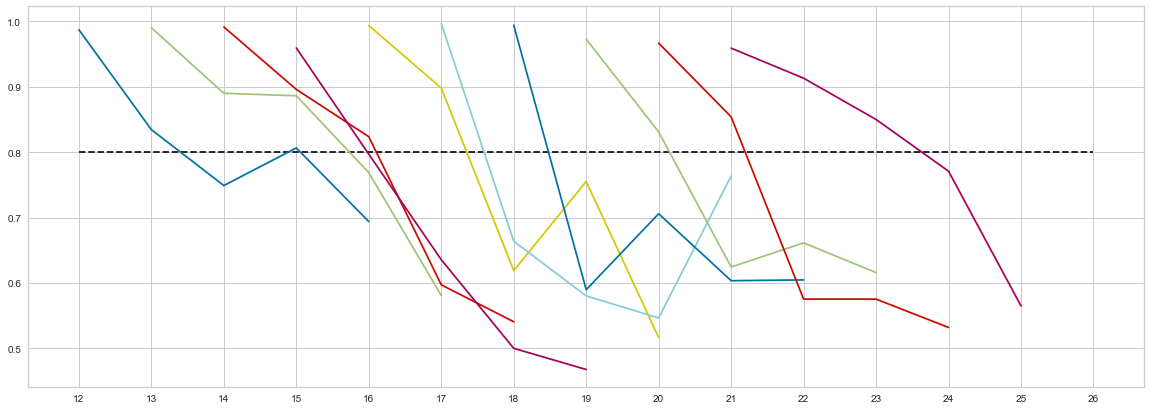

In [164]:
# number of month
fromNbMonthStart = 12
fromNbMonthEnd = 22
plt.figure(figsize=(20, 7))
plt.hlines(0.8, 12, 26, colors='k', linestyles='dashed')
for j in range(fromNbMonthStart, fromNbMonthEnd):
    listARIScore = []
    for i in range(j, j+5):
        listARIScore.append(calcARIScore(data, 7, j, i))
    plt.plot(range(j, j+5), listARIScore)
plt.xticks(range(fromNbMonthStart, fromNbMonthEnd+5))
plt.show()

## 22.6 Conclusion & Proposition de contrat de maintenance

Nous observons que l'*Adjusted_Rand_Score* n'est pas très stable<br />
au cours du temps et passe la barre de 0.8 après une période<br />
de 1 mois et demi en moyenne.

Dans une simulation de contrat de maintenance, je proposerais<br />
un contrat incluant un recalcul des clusters tous les mois.
